Entrega : 01

Grupo : 07

# Load

In [134]:
##Instalamos las librerias
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer

# pre processing categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [135]:
# from google.colab import drive
# drive.mount('/content/drive')

# Ruta Maria
#path_proyecto ='/content/drive/MyDrive/Machine Learning_Entregables/Entregable 1/data_inter'

# # Ruta Eliane
# path_proyecto ='/content/drive/MyDrive/2026/2026-0/Machine learning/data_inter' 

# os.chdir(path_proyecto)
# os.getcwd()

In [136]:
# Obtener directorio base 
BASE_DIR = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd().parent

# Si estamos en scripts, subir un nivel; si no, usar cwd
if "scripts" in str(Path.cwd()):
    BASE_DIR = Path.cwd().parent
else:
    BASE_DIR = Path.cwd()

print(f"BASE_DIR: {BASE_DIR}")

# Rutas para datos
DATA_DIR = BASE_DIR / "data"
RAW_DATA_PATH = DATA_DIR / "raw"
INTER_DATA_PATH = DATA_DIR / "inter"
FINAL_DATA_PATH = DATA_DIR / "final"
# Rutas para gráficos, scripts y documentación
GRAPHS_DIR = BASE_DIR / "graphs"
GRAPHS_PATH_INCOME = GRAPHS_DIR / "data_income"
GRAPHS_PATH_LENDING = GRAPHS_DIR / "data_lending"
SCRIPTS_PATH = BASE_DIR / "scripts"
DOCS_PATH = BASE_DIR / "docs"

print(f"RAW_DATA_PATH: {RAW_DATA_PATH}")
print(f"Existe: {RAW_DATA_PATH.exists()}")

BASE_DIR: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07
RAW_DATA_PATH: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07\data\raw
Existe: True


In [137]:
# cargando datos
df_raw = pd.read_excel(RAW_DATA_PATH / "lending_dataset.xlsx")
df_raw = df_raw.drop(columns=["index"])

In [138]:
df_raw.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'revol_util', 'application_type',
       'pub_rec_bankruptcies'],
      dtype='object')

In [139]:
df_raw.shape

(19908, 19)

# EDA

In [140]:
TARGET_CLAS = "loan_status"  # variable objetivo para clasificación

# selecciona las columnas numéricas y categóricas excepto la variable objetivo

num_raw = df_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_raw = df_raw.select_dtypes(include=['object', "category", "bool"]).columns.tolist()
cat_raw.remove(TARGET_CLAS)

print("=== Variables Identificadas ===")
print("Target de clasificación:", TARGET_CLAS)
print("Variables numéricas para clasificación:", num_raw)
print("Variables categóricas para clasificación:", cat_raw)
print("--------------------------------")

=== Variables Identificadas ===
Target de clasificación: loan_status
Variables numéricas para clasificación: ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies']
Variables categóricas para clasificación: ['grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']
--------------------------------


### 1. Análisis estadístico inicial

In [141]:
def eda_numericas_descriptivas(df, num_cols, top_n=5):
    """
    Realiza EDA descriptivo para variables numéricas.

    Args:
        df: DataFrame a analizar
        num_cols: Lista de columnas numéricas
        top_n: Número de valores más frecuentes a mostrar
    """

    num_cols = df.select_dtypes(include="number").columns.tolist()

    if "index" in num_cols:
        num_cols.remove("index")

    print("\n" + "=" * 50)
    print(" ESTATÍSTICAS DESCRIPTIVAS")
    print("=" * 50)
    display(df[num_cols].describe().T.round(2))

    print("\n" + "=" * 50)
    print("QUANTILES (1%, 25%, 50%, 75%, 99%)")
    print("=" * 50)
    display(df[num_cols].quantile([0.01, 0.25, 0.5, 0.75, 0.99]).T.round(2))

    print("\n" + "=" * 50)
    print(f"TOP {top_n} VALORES MÁS FRECUENTES POR VARIABLE")
    print("=" * 50)
    for col in num_cols:
        print(f"\n--- {col} ---")
        display(df[col].value_counts().head(top_n).round(2))

In [142]:
# clasificación
eda_numericas_descriptivas(df_raw, num_raw, 5)


 ESTATÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
loan_amnt,19908.0,11353.85,7463.70,500.00,5750.00,10000.00,15000.00,35000.00
term,19908.0,42.10,10.45,36.00,36.00,36.00,60.00,60.00
int_rate,19908.0,12.09,3.70,5.42,9.45,11.86,14.61,24.40
installment,19908.0,330.61,210.56,15.69,171.29,285.78,440.82,1302.69
annual_inc,19905.0,71074.71,69810.72,4000.00,42000.00,60000.00,85000.00,6000000.00
dti,19897.0,13.01,6.66,0.00,7.84,13.08,18.20,29.99
delinq_2yrs,19899.0,0.14,0.49,0.00,0.00,0.00,0.00,11.00
revol_util,19880.0,49.74,49.82,0.00,26.50,50.30,72.80,5829.00
pub_rec_bankruptcies,19587.0,0.04,0.19,0.00,0.00,0.00,0.00,2.00



QUANTILES (1%, 25%, 50%, 75%, 99%)


,0.01,0.25,0.50,0.75,0.99
loan_amnt,1200.00,5750.00,10000.00,15000.00,35000.00
term,36.00,36.00,36.00,60.00,60.00
int_rate,5.42,9.45,11.86,14.61,20.99
installment,39.14,171.29,285.78,440.82,933.13
annual_inc,14400.00,42000.00,60000.00,85000.00,248003.84
dti,0.35,7.84,13.08,18.20,26.26
delinq_2yrs,0.00,0.00,0.00,0.00,2.00
revol_util,0.00,26.50,50.30,72.80,98.50
pub_rec_bankruptcies,0.00,0.00,0.00,0.00,1.00



TOP 5 VALORES MÁS FRECUENTES POR VARIABLE

--- loan_amnt ---


loan_amnt
10000    1466
12000    1208
5000     1026
6000      994
15000     984
Name: count, dtype: int64


--- term ---


term
36    14852
60     5056
Name: count, dtype: int64


--- int_rate ---


int_rate
10.99    492
11.49    407
13.49    406
7.51     384
7.88     381
Name: count, dtype: int64


--- installment ---


installment
311.11    37
180.96    37
368.45    33
311.02    30
325.74    28
Name: count, dtype: int64


--- annual_inc ---


annual_inc
60000.0    794
50000.0    554
40000.0    445
45000.0    431
75000.0    425
Name: count, dtype: int64


--- dti ---


dti
0.00     84
14.29    25
12.48    23
6.00     23
12.00    22
Name: count, dtype: int64


--- delinq_2yrs ---


delinq_2yrs
0.0    17780
1.0     1616
2.0      341
3.0      111
4.0       29
Name: count, dtype: int64


--- revol_util ---


revol_util
0.0     455
0.2      38
78.7     34
32.0     34
57.4     33
Name: count, dtype: int64


--- pub_rec_bankruptcies ---


pub_rec_bankruptcies
0.0    18844
1.0      742
2.0        1
Name: count, dtype: int64

### 1.2) Categóricas - frecuencias

In [143]:
def eda_categoricas_descriptivas(df, cat_cols, top_n=10):
    """
    Realiza EDA descriptivo para variables categóricas.

    Args:
        df: DataFrame a analizar
        cat_cols: Lista de columnas categóricas
        top_n: Número de categorías más frecuentes a mostrar
    """
    print("=" * 50)
    print("VALORES ÚNICOS POR VARIABLE")
    print("=" * 50)
    display(df[cat_cols].nunique().to_frame("n_unique"))

    print("\n" + "=" * 50)
    print(f"TOP {top_n} FRECUENCIAS POR VARIABLE")
    print("=" * 50)
    for col in cat_cols:
        print(f"\n--- {col} ---")
        display(df[col].value_counts(dropna=False).head(top_n))

In [144]:
# clasificación
eda_categoricas_descriptivas(df_raw, cat_raw)

VALORES ÚNICOS POR VARIABLE


,n_unique
grade,7
emp_title,15047
emp_length,11
home_ownership,5
verification_status,3
pymnt_plan,1
purpose,14
addr_state,8
application_type,2



TOP 10 FRECUENCIAS POR VARIABLE

--- grade ---


grade
B    6065
A    4875
C    4087
D    2748
E    1434
F     540
G     159
Name: count, dtype: int64


--- emp_title ---


emp_title
NaN                    1185
Bank of America          53
Kaiser Permanente        50
State of California      42
US Army                  40
AT&T                     36
JP Morgan Chase          27
IBM                      25
Verizon                  24
UPS                      23
Name: count, dtype: int64


--- emp_length ---


emp_length
10+ years    4249
< 1 year     2304
2 years      2218
3 years      2108
4 years      1871
5 years      1649
1 year       1636
6 years      1151
7 years       867
8 years       718
Name: count, dtype: int64


--- home_ownership ---


home_ownership
RENT        10965
MORTGAGE     7349
OWN          1546
OTHER          44
NaN             3
NONE            1
Name: count, dtype: int64


--- verification_status ---


verification_status
Not Verified       8256
Verified           6464
Source Verified    5185
NaN                   3
Name: count, dtype: int64


--- pymnt_plan ---


pymnt_plan
s    19908
Name: count, dtype: int64


--- purpose ---


purpose
debt_consolidation    9387
credit_card           2696
other                 2059
home_improvement      1330
major_purchase        1048
small_business         905
car                    687
wedding                539
medical                350
moving                 317
Name: count, dtype: int64


--- addr_state ---


addr_state
CA       7101
NY       3813
FL       2870
TX       2733
NJ       1855
IL       1525
NaN         9
951xx       1
106xx       1
Name: count, dtype: int64


--- application_type ---


application_type
Individual    19906
1                 2
Name: count, dtype: int64

## 2. Análisis de calidad (diagnóstico)

### 2.1) Numéricas

In [145]:
def eda_calidad_numericas(df, num_cols):

    print("\nVariables numéricas analizadas:")
    print(num_cols)

    # 1) Información general
    print("\n" + "=" * 50)
    print("INFORMACIÓN GENERAL (dtypes, nulos)")
    print("=" * 50)
    df[num_cols].info()

    # 2) Diagnóstico de dtypes incorrectos
    print("\n" + "=" * 50)
    print("DIAGNÓSTICO DE DTYPES INCORRECTOS")
    print("=" * 50)

    dtype_rows = []
    for col in num_cols:
        serie_original = df[col]
        serie_coerce = pd.to_numeric(serie_original, errors="coerce")

        dtype_rows.append({
            "variable": col,
            "dtype_original": serie_original.dtype,
            "NaN_antes": serie_original.isna().sum(),
            "NaN_despues_coerce": serie_coerce.isna().sum(),
            "valores_no_numericos": serie_coerce.isna().sum() - serie_original.isna().sum()
        })

    dtype_diag = pd.DataFrame(dtype_rows)
    display(dtype_diag)

    # 3) Análisis de missings redondeado a 2 decimales

    print("\n" + "=" * 50)
    print("ANÁLISIS DE MISSINGS")
    print("=" * 50)

    missing_num = (
        df[num_cols]
        .isna()
        .mean()
        .round(4)
        .sort_values(ascending=False)
        .to_frame("pct_missing")
    )
    display(missing_num)

    # 4) Análisis de outliers
    print("\n" + "=" * 50)
    print("ANÁLISIS DE OUTLIERS")
    print("=" * 50)

    quantiles_num = df[num_cols].quantile([0.01, 0.50, 0.99]).T
    quantiles_num.columns = ["p1", "p50", "p99"]

    min_max_num = df[num_cols].agg(["min", "max"]).T

    outliers_num = pd.concat([min_max_num, quantiles_num], axis=1)
    outliers_num = outliers_num[["min", "p1", "p50", "p99", "max"]]
    display(outliers_num)

    # 5) Análisis de duplicados
    print("\n" + "=" * 50)
    print("ANÁLISIS DE DUPLICADOS")
    print("=" * 50)

    n_duplicados = df.duplicated().sum()
    print(f"Número de filas duplicadas: {n_duplicados}")

In [146]:
eda_calidad_numericas(df_raw, num_raw)


Variables numéricas analizadas:
['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies']

INFORMACIÓN GENERAL (dtypes, nulos)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             19908 non-null  int64  
 1   term                  19908 non-null  int64  
 2   int_rate              19908 non-null  float64
 3   installment           19908 non-null  float64
 4   annual_inc            19905 non-null  float64
 5   dti                   19897 non-null  float64
 6   delinq_2yrs           19899 non-null  float64
 7   revol_util            19880 non-null  float64
 8   pub_rec_bankruptcies  19587 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB

DIAGNÓSTICO DE DTYPES INCORRECTOS


,variable,dtype_original,NaN_antes,NaN_despues_coerce,valores_no_numericos
0,loan_amnt,int64,0,0,0
1,term,int64,0,0,0
2,int_rate,float64,0,0,0
3,installment,float64,0,0,0
4,annual_inc,float64,3,3,0
5,dti,float64,11,11,0
6,delinq_2yrs,float64,9,9,0
7,revol_util,float64,28,28,0
8,pub_rec_bankruptcies,float64,321,321,0



ANÁLISIS DE MISSINGS


,pct_missing
pub_rec_bankruptcies,0.0161
revol_util,0.0014
dti,0.0006
delinq_2yrs,0.0005
annual_inc,0.0002
loan_amnt,0.0000
installment,0.0000
term,0.0000
int_rate,0.0000



ANÁLISIS DE OUTLIERS


,min,p1,p50,p99,max
loan_amnt,500.00,1200.0000,10000.00,35000.0000,35000.00
term,36.00,36.0000,36.00,60.0000,60.00
int_rate,5.42,5.4200,11.86,20.9900,24.40
installment,15.69,39.1449,285.78,933.1337,1302.69
annual_inc,4000.00,14400.0000,60000.00,248003.8400,6000000.00
dti,0.00,0.3500,13.08,26.2600,29.99
delinq_2yrs,0.00,0.0000,0.00,2.0000,11.00
revol_util,0.00,0.0000,50.30,98.5000,5829.00
pub_rec_bankruptcies,0.00,0.0000,0.00,1.0000,2.00



ANÁLISIS DE DUPLICADOS
Número de filas duplicadas: 0


### 2.2) Categóricas

In [147]:
def eda_calidad_categoricas(df, cat_cols, umbral_low_freq=0.01):
    """
    Args:
        df: DataFrame a analizar
        cat_cols: Lista de columnas categóricas
        nombre_dataset: Nombre del dataset para identificación
        umbral_low_freq: Umbral para detectar categorías con baja frecuencia (default 1%)
    """
    print("\nVariables categóricas analizadas:")
    print(cat_cols)

    # 1) Análisis de missings
    print("\n" + "=" * 50)
    print("ANÁLISIS DE MISSINGS")
    print("=" * 50)

    missing_cat = (
        df[cat_cols]
        .isna()
        .mean()
        .round(4)
        .sort_values(ascending=False)
        .to_frame("pct_missing")
    )
    display(missing_cat)

    # 2) Análisis de missings codificados
    print("\n" + "=" * 50)
    print("MISSINGS CODIFICADOS (vacíos, '?')")
    print("=" * 50)

    rows_missing_cod = []
    for col in cat_cols:
        conteo_vacio = (df[col].astype(str).str.strip() == "").sum()
        conteo_preg = (df[col].astype(str).str.strip() == "?").sum()

        rows_missing_cod.append({
            "variable": col,
            "empty_string": conteo_vacio,
            "question_mark": conteo_preg
        })

    missing_cod = pd.DataFrame(rows_missing_cod)
    display(missing_cod)

    # 3) Categorías con baja frecuencia
    print("\n" + "=" * 50)
    print(f"CATEGORÍAS CON FRECUENCIA < {umbral_low_freq*100:.0f}%")
    print("=" * 50)

    rows_low_freq = []
    for col in cat_cols:
        freq = df[col].value_counts(normalize=True)
        low_freq = freq[freq < umbral_low_freq]

        for categoria, propor in low_freq.items():
            rows_low_freq.append({
                "variable": col,
                "categoria": categoria,
                "frecuencia_relativa": round(propor, 4)
            })

    low_freq_df = pd.DataFrame(rows_low_freq)

    if low_freq_df.empty:
        print("No se identificaron categorías con baja frecuencia.")
    else:
        display(low_freq_df)

In [148]:
# clasificación
eda_calidad_categoricas(df_raw, cat_raw)


Variables categóricas analizadas:
['grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']

ANÁLISIS DE MISSINGS


,pct_missing
emp_title,0.0595
emp_length,0.0252
addr_state,0.0005
verification_status,0.0002
home_ownership,0.0002
purpose,0.0002
grade,0.0000
pymnt_plan,0.0000
application_type,0.0000



MISSINGS CODIFICADOS (vacíos, '?')


,variable,empty_string,question_mark
0,grade,0,0
1,emp_title,0,0
2,emp_length,0,0
3,home_ownership,0,0
4,verification_status,0,0
5,pymnt_plan,0,0
6,purpose,0,0
7,addr_state,0,0
8,application_type,0,0



CATEGORÍAS CON FRECUENCIA < 1%


,variable,categoria,frecuencia_relativa
0,grade,G,0.0080
1,emp_title,Bank of America,0.0028
2,emp_title,Kaiser Permanente,0.0027
3,emp_title,State of California,0.0022
4,emp_title,US Army,0.0021
...,...,...,...
15052,purpose,educational,0.0081
15053,purpose,renewable_energy,0.0026
15054,addr_state,951xx,0.0001
15055,addr_state,106xx,0.0001


## 3) Preprocesamiento

In [149]:
# df_lending_inter = pd.read_csv("lending_inter.csv")
# df_lending_inter = df_lending_inter.drop(columns=["index"])

#### 3.1) Numéricas

In [150]:
df_inter = df_raw.copy()
num_inter = df_inter.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_inter = df_inter.select_dtypes(include=['object', "category", "bool"]).columns.tolist()

In [151]:
def imputar_missings_numericas(df, num_cols, estrategia="median"):
    """
    Imputa missings en variables numéricas.

    Args:
        df: DataFrame a procesar
        num_cols: Lista de columnas numéricas
        estrategia: Estrategia de imputación ("mean", "median", "zero")

    Returns:
        DataFrame con resumen de imputación
    """
    df = df.copy()
    
    resumen = []

    for col in num_cols:
        n_missing = df[col].isna().sum()
        pct_missing = df[col].isna().mean() * 100

        if estrategia == "mean":
            valor_imputar = df[col].mean()
        elif estrategia == "median":
            valor_imputar = df[col].median()
        elif estrategia == "zero":
            valor_imputar = 0
        else:
            raise ValueError("Estrategia no reconocida. Use 'mean', 'median' o 'zero'.")

        df[col].fillna(valor_imputar, inplace=True)

        resumen.append({
            "variable": col,
            "n_missings_imputados": n_missing,
            "pct_missings_imputados": round(pct_missing, 2),
            "valor_imputado": round(valor_imputar, 4)
        })

    resumen_df = pd.DataFrame(resumen)

    print(f"Estrategia usada: {estrategia}")

    return resumen_df

In [152]:
imputar_missings_numericas(df_inter, num_inter, estrategia="median")

Estrategia usada: median


C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1071835584.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(valor_imputar, inplace=True)


,variable,n_missings_imputados,pct_missings_imputados,valor_imputado
0,loan_amnt,0,0.00,10000.00
1,term,0,0.00,36.00
2,int_rate,0,0.00,11.86
3,installment,0,0.00,285.78
4,annual_inc,3,0.02,60000.00
5,dti,11,0.06,13.08
6,delinq_2yrs,9,0.05,0.00
7,revol_util,28,0.14,50.30
8,pub_rec_bankruptcies,321,1.61,0.00


In [153]:
def transformar_log(df, cols, drop_original=True):
    df = df.copy()

    if isinstance(cols, str):
        cols = [cols]

    print("Columnas transformadas (log):")

    for col in cols:
        sesgo_antes = df[col].skew()

        # np.log1p soporta NaN
        df[f"{col}_log"] = np.log1p(df[col])

        sesgo_despues = df[f"{col}_log"].skew()

        if drop_original:
            df.drop(columns=[col], inplace=True)

        print(
            f"  {col}: sesgo antes {sesgo_antes:.4f} "
            f"-> sesgo después {sesgo_despues:.4f}"
        )
    return df

Skew (sesgo) es una medida de asimetría de la distribución de datos:

- Skew = 0: distribución simétrica
- Skew > 0: cola derecha más larga (sesgo positivo)
- Skew < 0: cola izquierda más larga (sesgo negativo)

In [154]:
# dataset clasificación
# columnas: - loan_amnt - annual_inc
df_inter = transformar_log(df_inter, ["loan_amnt", "annual_inc"])

Columnas transformadas (log):
  loan_amnt: sesgo antes 1.0535 -> sesgo después -0.4849
  annual_inc: sesgo antes 35.9101 -> sesgo después 0.1410


#### 3.2) Categóricas

In [ ]:
def limpiar_categoricas(
    df,
    cat_cols,
    imputar_valor="Missing",
    verbose=True
):
    """
    Limpia variables categóricas:
    1. strip() para unificar categorías
    2. reemplaza '?' por NaN
    3. imputa missings con un valor constante

    Args:
        df: DataFrame original
        cat_cols: lista de columnas categóricas
        imputar_valor: valor para imputar missings
        verbose: muestra resumen por columna
    """
    df = df.copy()
    imputer = SimpleImputer(strategy="constant", fill_value=imputar_valor)

    if verbose:
        print("Limpieza de variables categóricas:")

    for col in cat_cols:
        # strip
        nunique_antes = df[col].nunique()
        df[col] = df[col].astype(str).str.strip()
        nunique_despues = df[col].nunique()

        # '?' -> NaN
        conteo_interrogacion = (df[col] == "?").sum()
        df[col] = df[col].replace("?", np.nan)

        # imputación
        missing_antes = df[col].isna().sum()
        df[col] = imputer.fit_transform(df[[col]]).ravel()
        missing_despues = df[col].isna().sum()

        if verbose:
            display(
                f"{col}: "
                f"nunique {nunique_antes}->{nunique_despues}, "
                f"'?' {conteo_interrogacion}, "
                f"missing {missing_antes}->{missing_despues}"
            )

    return df

In [160]:
df_inter = limpiar_categoricas(df_inter, cat_inter)

Limpieza de variables categóricas:


"grade: nunique 7->7, '?' 0, missing 0->0"

"emp_title: nunique 15047->14934, '?' 0, missing 0->0"

"emp_length: nunique 11->12, '?' 0, missing 0->0"

"home_ownership: nunique 5->6, '?' 0, missing 0->0"

"verification_status: nunique 3->4, '?' 0, missing 0->0"

"loan_status: nunique 2->3, '?' 0, missing 0->0"

"pymnt_plan: nunique 1->1, '?' 0, missing 0->0"

"purpose: nunique 14->15, '?' 0, missing 0->0"

"addr_state: nunique 8->9, '?' 0, missing 0->0"

"application_type: nunique 2->2, '?' 0, missing 0->0"

**Nota:** OneHotEncoder se aplicarán solo a variables con pocas categorías en etapas posteriores del modelado.

In [162]:
# label encoding para variables categóricas 
# grade ->  array(['C', 'E', 'F', 'B', 'A', 'D', 'G'], dtype=object)

df_inter['grade_num'] = df_inter['grade'].map({
                                'A': 1,
                                'B': 2,
                                'C': 3,     
                                'D': 4,
                                'E': 5,
                                'F': 6,
                                'G': 7
                            })


In [163]:
# convertiendo a numerico emp_length
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0,
    'n/a': np.nan
}
df_inter['emp_length_num'] = df_inter['emp_length'].map(emp_length_mapping)

In [164]:
# drop grade y emp_length
df_inter = df_inter.drop(columns=['grade', 'emp_length'])

## 4) Análisis Exploratorio (EDA univariado) y Visualización

In [165]:
df_inter = df_inter.copy()
num_inter = df_inter.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_inter = df_inter.select_dtypes(include=['object', "category", "bool"]).columns.tolist()

### 4.1) Numéricas: descriptivo y visualización

In [167]:
def eda_univariado_numericas(df_raw, df_inter, num_raw, num_inter):

    print("\nVariables numéricas analizadas:")
    print(num_inter)

    n_vars = len(num_inter)
    n_cols_plot = 2 if n_vars <= 6 else 3
    n_rows = math.ceil(n_vars / n_cols_plot)

    # ===================== HISTOGRAMAS =====================
    print("\n--- Histogramas ---")
    plt.figure(figsize=(5 * n_cols_plot, 3.5 * n_rows))

    for i, col in enumerate(num_inter, 1):
        plt.subplot(n_rows, n_cols_plot, i)
        sns.histplot(df_inter[col], bins=30, kde=True)
        plt.title(f"Histograma de {col}", fontsize=11)
        plt.xlabel("")
        plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "numericas_histogramas.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ===================== COMPARACIÓN LOG =====================
    print("\n--- Comparación log antes vs después ---")

    cols_log = [c for c in num_inter if c.endswith("_log")]

    if not cols_log:
        print("No se aplicaron transformaciones logarítmicas.")
    else:
        for col_log in cols_log:
            num_raw = col_log.replace("_log", "")

            if num_raw not in df_raw.columns:
                print(f"Columna original '{num_raw}' no encontrada en df_raw.")
                continue

            plt.figure(figsize=(12, 4))

            # Raw
            plt.subplot(1, 2, 1)
            sns.histplot(df_raw[num_raw], bins=30, kde=True)
            plt.title(f"Raw: {num_raw} (skew: {df_raw[num_raw].skew():.2f})")
            plt.xlabel("")

            # Log
            plt.subplot(1, 2, 2)
            sns.histplot(df_inter[col_log], bins=30, kde=True)
            plt.title(f"Log: {col_log} (skew: {df_inter[col_log].skew():.2f})")
            plt.xlabel("")

            plt.tight_layout()
            plt.savefig(
                GRAPHS_PATH_LENDING / f"{num_raw}_raw_vs_log.png",
                dpi=300,
                bbox_inches="tight"
            )
            plt.show()

    # ===================== BOXPLOTS =====================
    print("\n--- Boxplots ---")
    plt.figure(figsize=(5 * n_cols_plot, 2.8 * n_rows))

    for i, col in enumerate(num_inter, 1):
        plt.subplot(n_rows, n_cols_plot, i)
        sns.boxplot(x=df_inter[col])
        plt.title(f"Boxplot de {col}", fontsize=11)
        plt.xlabel("")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "numericas_boxplots.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ===================== BARPLOTS DISCRETAS =====================
    print("\n--- Barplots (variables discretas) ---")
    discretas = [col for col in num_inter if df_inter[col].nunique() <= 15]

    if discretas:
        n_vars_d = len(discretas)
        n_cols_d = min(n_cols_plot, n_vars_d)
        n_rows_d = math.ceil(n_vars_d / n_cols_d)

        plt.figure(figsize=(5 * n_cols_d, 3.5 * n_rows_d))

        for i, col in enumerate(discretas, 1):
            plt.subplot(n_rows_d, n_cols_d, i)
            counts = df_inter[col].value_counts().sort_index()
            sns.barplot(x=counts.index.astype(str), y=counts.values)
            plt.title(f"Barplot de {col}", fontsize=11)
            plt.xlabel("")
            plt.ylabel("Frecuencia")

        plt.tight_layout()
        plt.savefig(
            GRAPHS_PATH_LENDING / "numericas_barplots_discretas.png",
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()
    else:
        print("No se identificaron variables numéricas discretas.")



Variables numéricas analizadas:
['term', 'int_rate', 'installment', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies', 'loan_amnt_log', 'annual_inc_log', 'grade_num', 'emp_length_num']

--- Histogramas ---


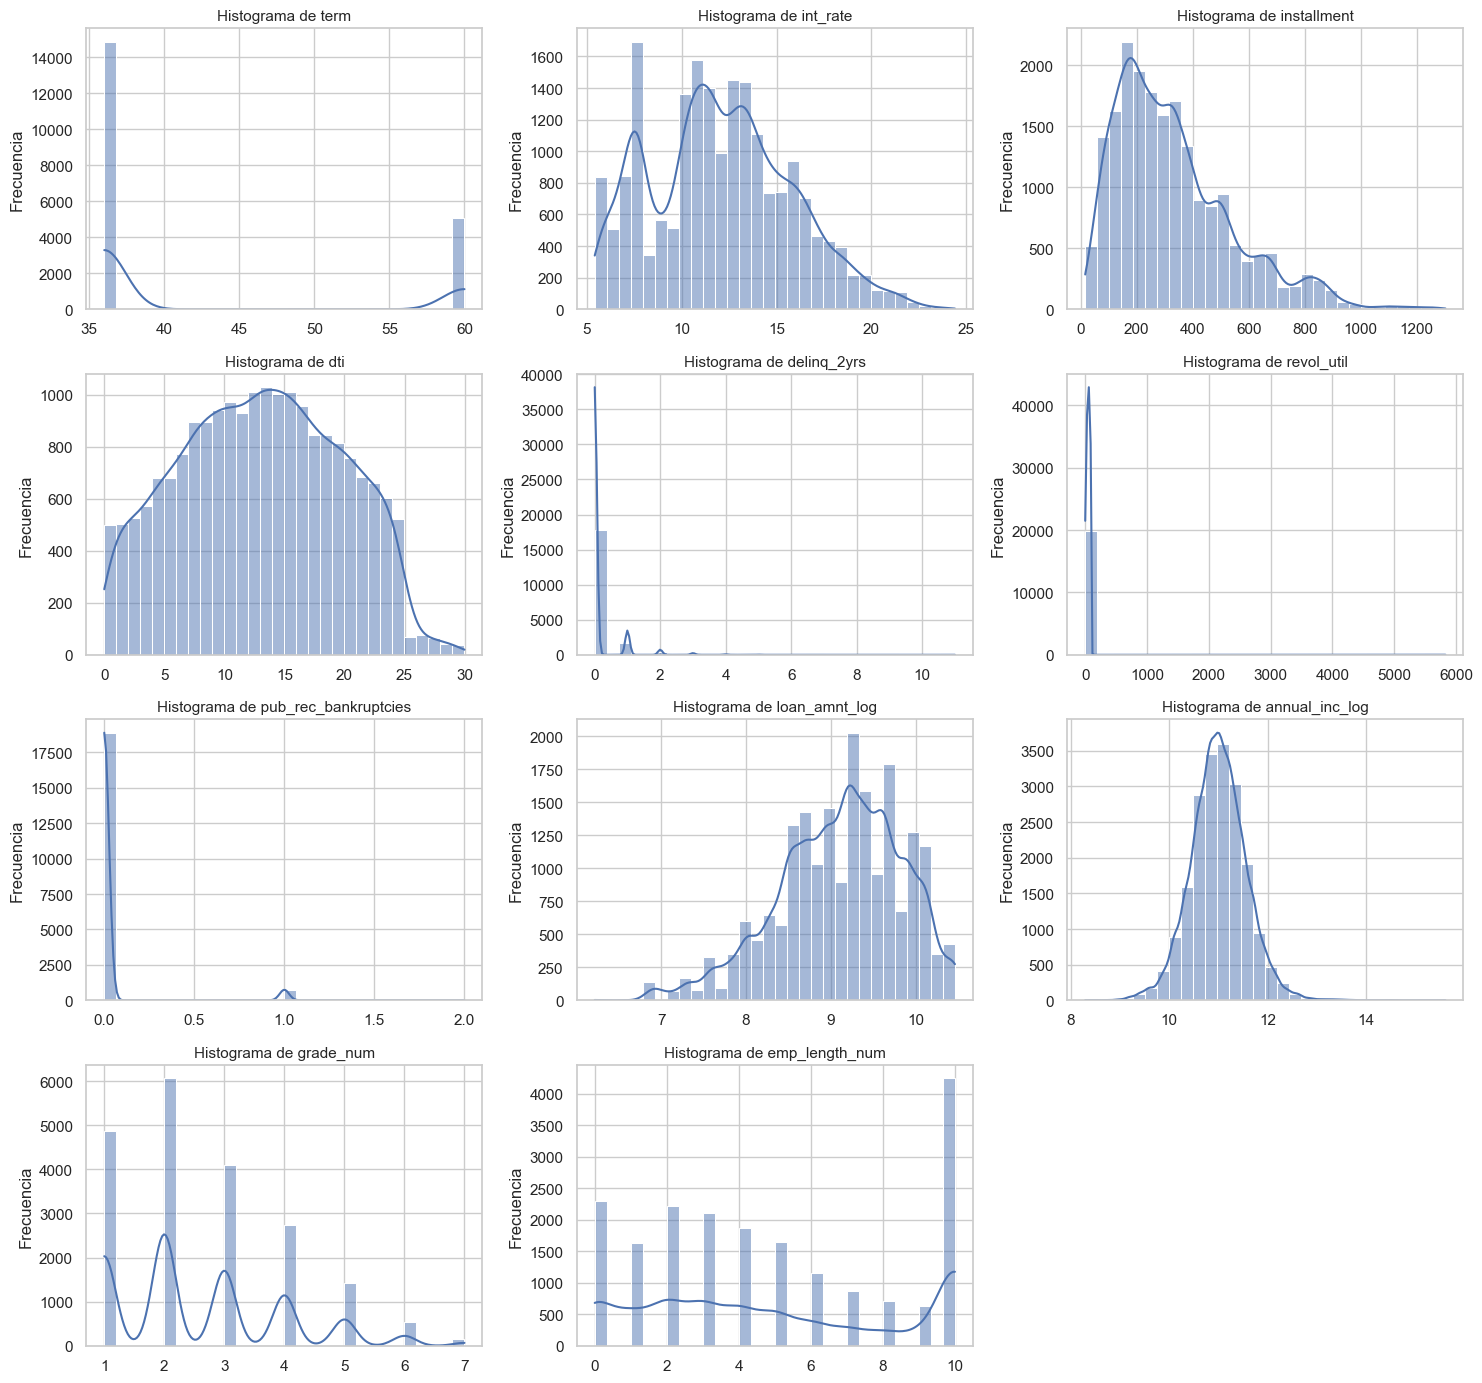


--- Comparación log antes vs después ---


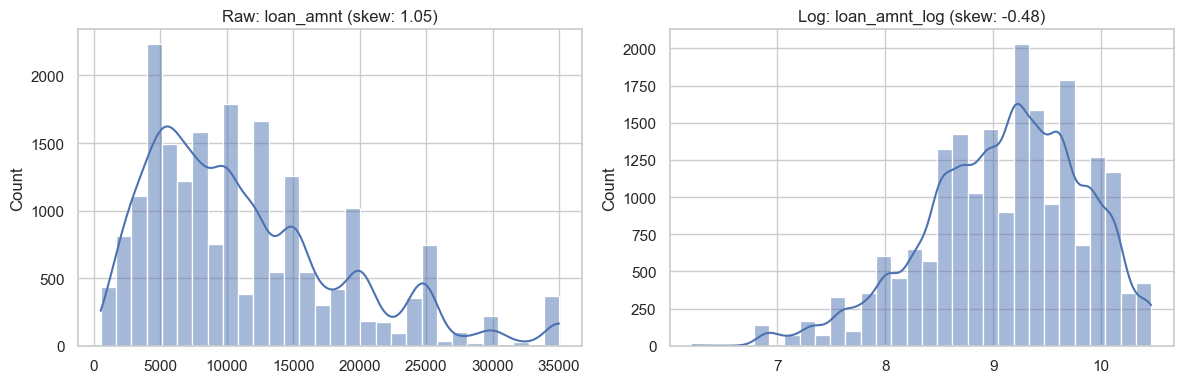

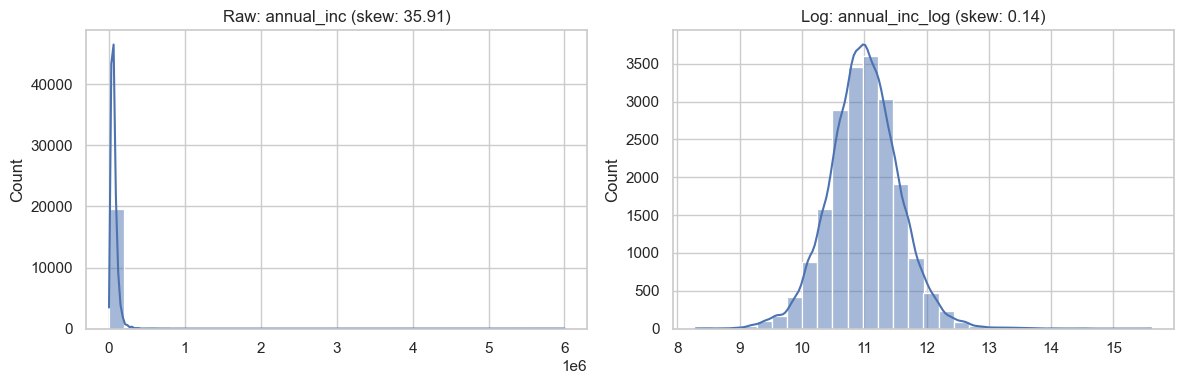


--- Boxplots ---


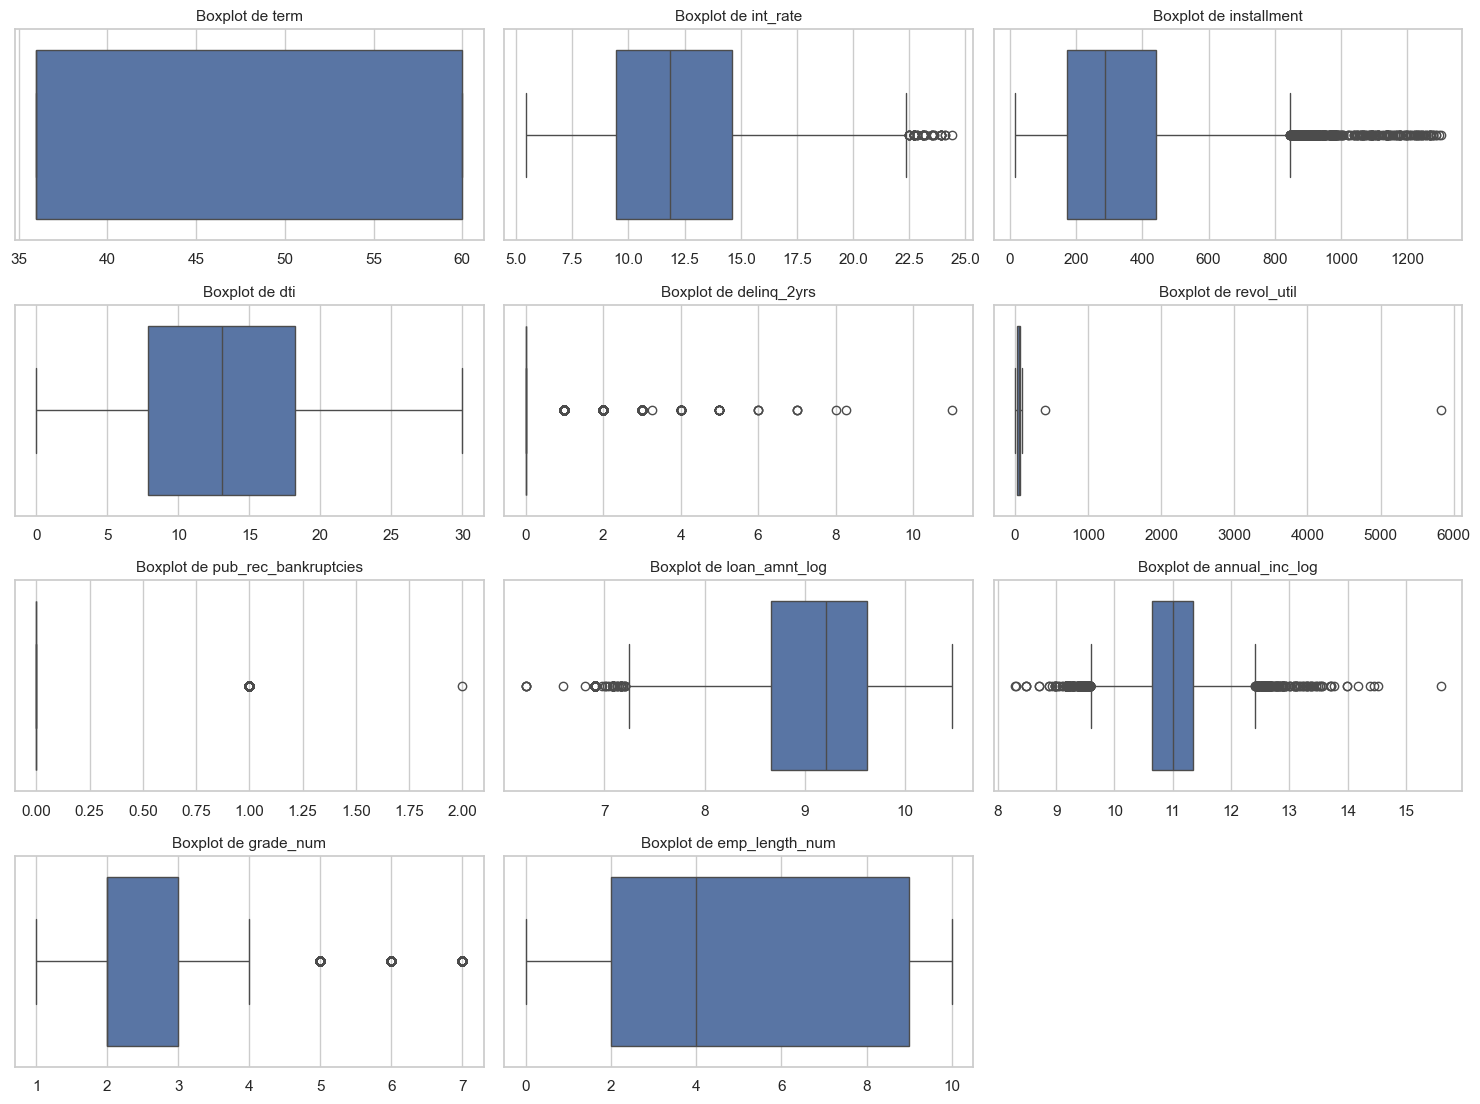


--- Barplots (variables discretas) ---


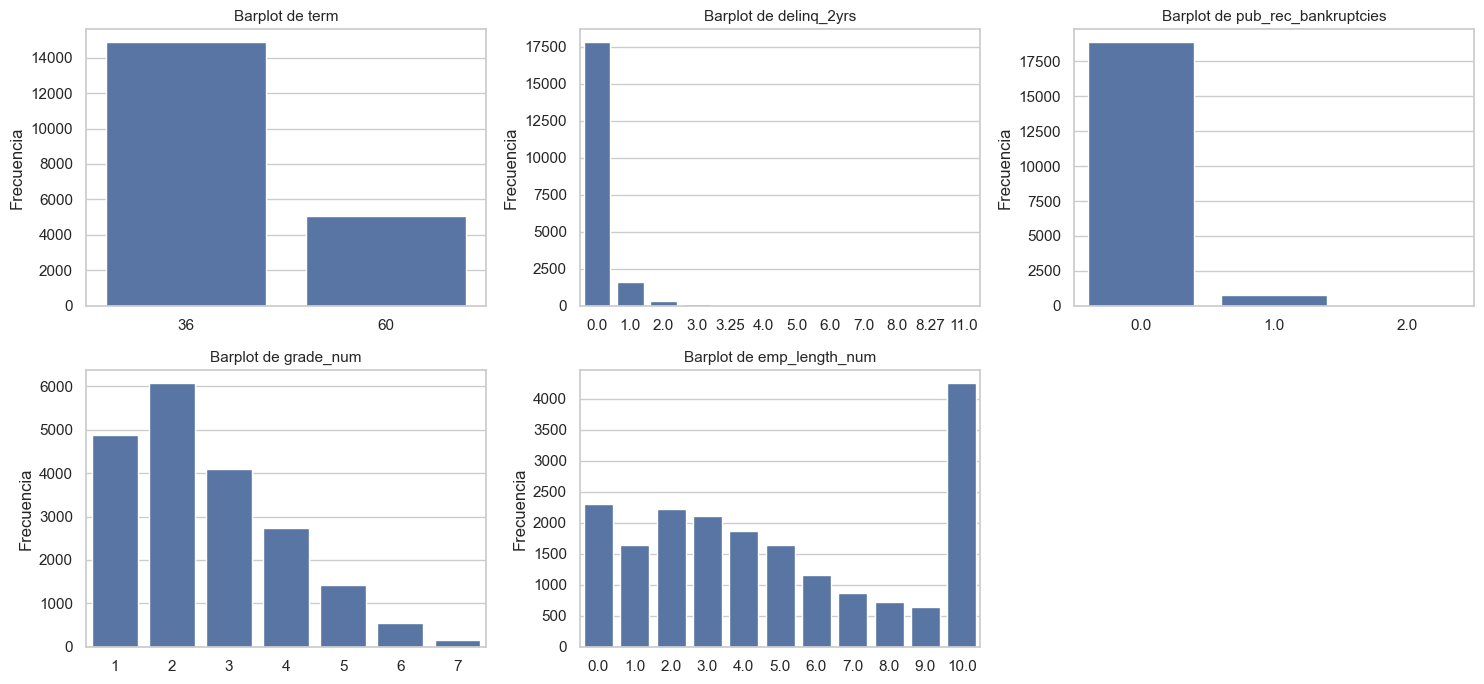

In [168]:
eda_univariado_numericas(df_raw, df_inter, num_raw, num_inter)

### 4.2) Categóricas: frecuencias y visualización

In [169]:
def eda_univariado_categoricas(df, cat_cols=None):

    # Identificar variables categóricas
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    print("\nVariables categóricas analizadas:")
    print(cat_cols)

    if not cat_cols:
        print("No se identificaron variables categóricas.")
        return

    # Parámetros visuales automáticos
    n_vars = len(cat_cols)
    n_cols = 2 if n_vars <= 6 else 3
    n_rows = math.ceil(n_vars / n_cols)

    # COUNT PLOTS (Top 10)=
    print("\n--- Countplots (Top 10 categorías) ---")

    plt.figure(figsize=(6*n_cols, 3.5*n_rows))

    for i, col in enumerate(cat_cols, 1):
        plt.subplot(n_rows, n_cols, i)

        order = df[col].value_counts().head(10).index

        sns.countplot(
            y=col,
            data=df,
            order=order
        )

        plt.title(f"Top 10 categorías — {col}", fontsize=11)
        plt.xlabel("Frecuencia")
        plt.ylabel("")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_INCOME / "countplots.png", dpi=300, bbox_inches='tight')
    plt.show()

    # TABLAS DE FRECUENCIAS (Top 10)
    print("\n--- Tablas de frecuencia (Top 10) ---")

    for col in cat_cols:
        print(f"\nVariable categórica: {col}")

        freq_table = (
            df[col]
            .value_counts(dropna=False)
            .to_frame("frecuencia")
        )

        freq_table["frecuencia_relativa"] = (
            freq_table["frecuencia"] / freq_table["frecuencia"].sum()
        ).round(3)

        display(freq_table.head(10))


Variables categóricas analizadas:
['emp_title', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']

--- Countplots (Top 10 categorías) ---


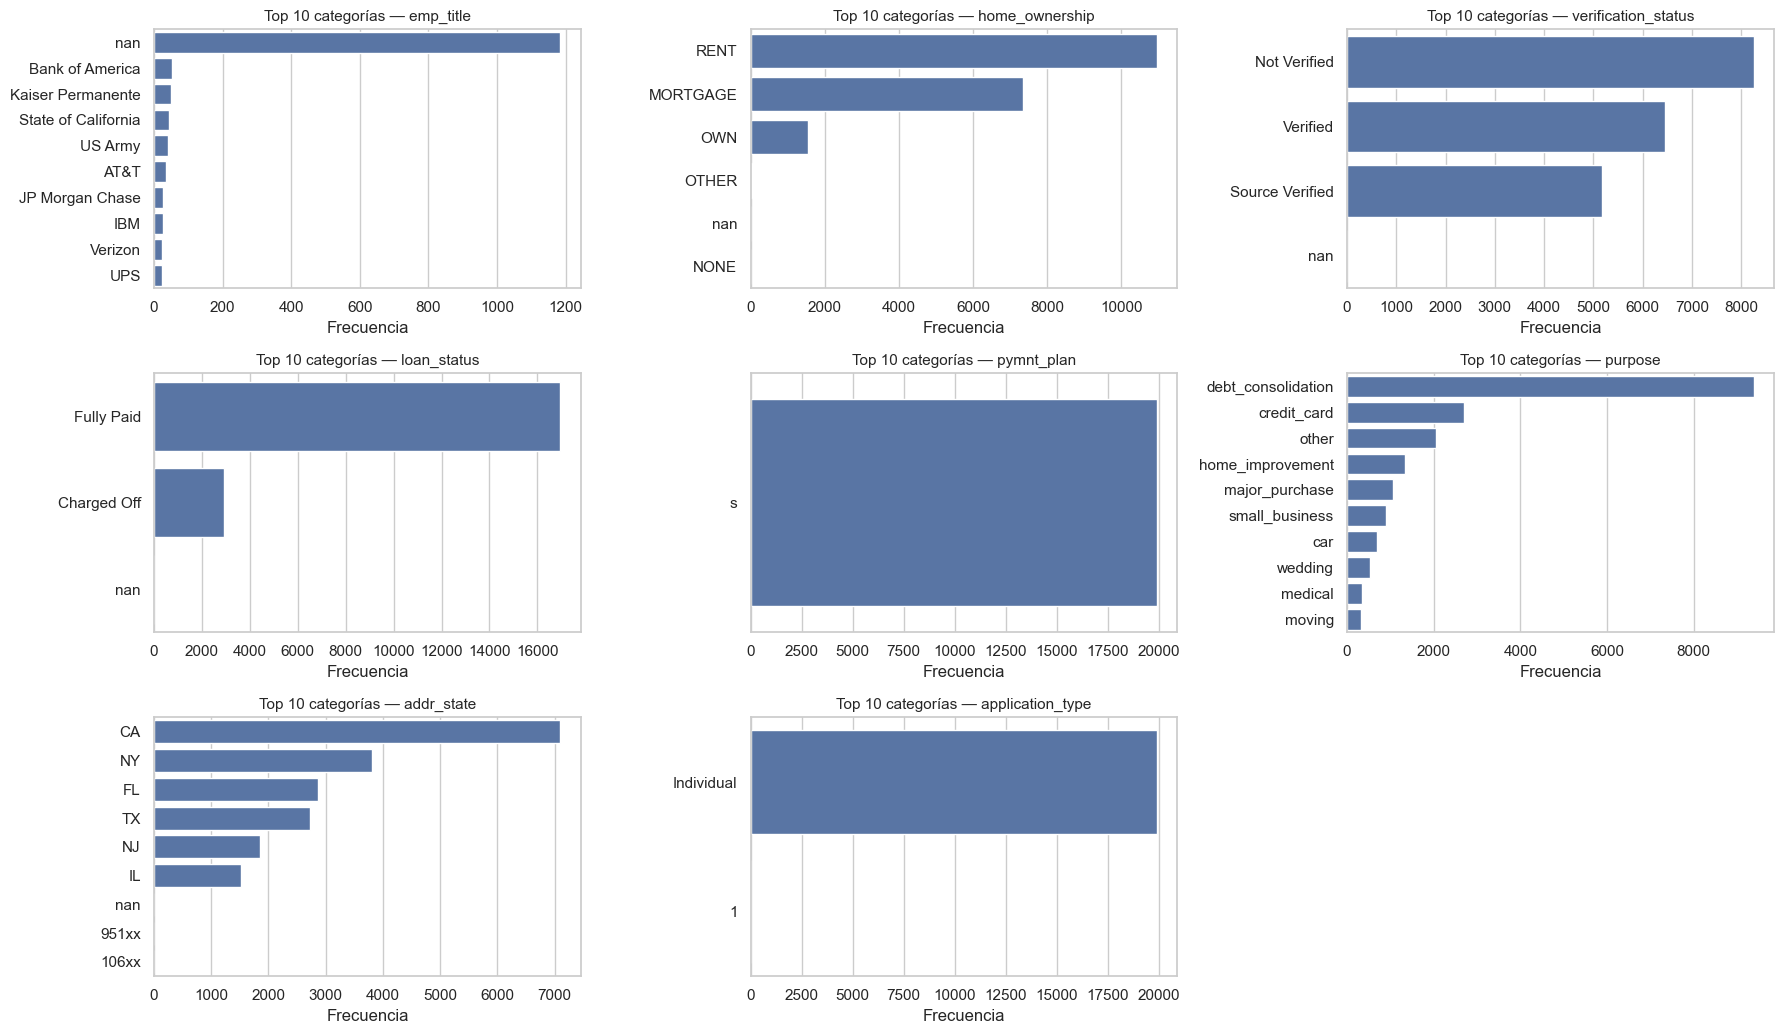


--- Tablas de frecuencia (Top 10) ---

Variable categórica: emp_title


,frecuencia,frecuencia_relativa
emp_title,,
nan,1185,0.060
Bank of America,53,0.003
Kaiser Permanente,50,0.003
State of California,43,0.002
US Army,41,0.002
AT&T,36,0.002
JP Morgan Chase,27,0.001
IBM,26,0.001
Verizon,24,0.001



Variable categórica: home_ownership


,frecuencia,frecuencia_relativa
home_ownership,,
RENT,10965,0.551
MORTGAGE,7349,0.369
OWN,1546,0.078
OTHER,44,0.002
nan,3,0.000
NONE,1,0.000



Variable categórica: verification_status


,frecuencia,frecuencia_relativa
verification_status,,
Not Verified,8256,0.415
Verified,6464,0.325
Source Verified,5185,0.260
nan,3,0.000



Variable categórica: loan_status


,frecuencia,frecuencia_relativa
loan_status,,
Fully Paid,16962,0.852
Charged Off,2943,0.148
nan,3,0.000



Variable categórica: pymnt_plan


,frecuencia,frecuencia_relativa
pymnt_plan,,
s,19908,1.0



Variable categórica: purpose


,frecuencia,frecuencia_relativa
purpose,,
debt_consolidation,9387,0.472
credit_card,2696,0.135
other,2059,0.103
home_improvement,1330,0.067
major_purchase,1048,0.053
small_business,905,0.045
car,687,0.035
wedding,539,0.027
medical,350,0.018



Variable categórica: addr_state


,frecuencia,frecuencia_relativa
addr_state,,
CA,7101,0.357
NY,3813,0.192
FL,2870,0.144
TX,2733,0.137
NJ,1855,0.093
IL,1525,0.077
nan,9,0.000
951xx,1,0.000
106xx,1,0.000



Variable categórica: application_type


,frecuencia,frecuencia_relativa
application_type,,
Individual,19906,1.0
1,2,0.0


In [170]:
eda_univariado_categoricas(df_inter, cat_inter)

### 4.3) Pre procesamiento ex-post

In [193]:
df_inter_cols = df_inter.copy()

4.3.1

In [194]:
# drop columns 

# features categoricos no informativos
df_inter_cols = df_inter_cols.drop(columns=["application_type", "pymnt_plan"])

# features categoricos no numericas

df_inter_cols = df_inter_cols.drop(columns=[ "delinq_2yrs", "pub_rec_bankruptcies", "revol_util"])

4.3.2

In [195]:
# emp_title , convertir categoria nan = other
df_inter_cols["emp_title"] = df_inter_cols["emp_title"].replace("nan", "Other")

4.3.3

In [196]:
# # converitr term en  binaria
df_inter_cols["term"] = df_inter_cols["term"].replace({36: " 36 months", 60: " 60 months"}).astype("category")

In [209]:
# limpiar "nan" de categoricas en todas las filas que tengan "nan" como string
for col in cat_inter:
    df_inter_cols[col] = df_inter_cols[col].replace("nan", "Missing")
    # limpiar missings 
    df_inter_cols = df_inter_cols.dropna(subset=[col])

In [210]:
# guardar df_clas_inter_drop_cols
# df_inter_cols.to_csv(INTER_DATA_PATH / "lending_clas_inter_drop_cols.csv", index=False)

num_inter = df_inter_cols.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_inter = df_inter_cols.select_dtypes(include=['object', "category", "bool"]).columns.tolist()

#### 4.4) EDA univariado ex post pre procesamiento


Variables numéricas analizadas:
['int_rate', 'installment', 'dti', 'loan_amnt_log', 'annual_inc_log', 'grade_num', 'emp_length_num']

--- Histogramas ---


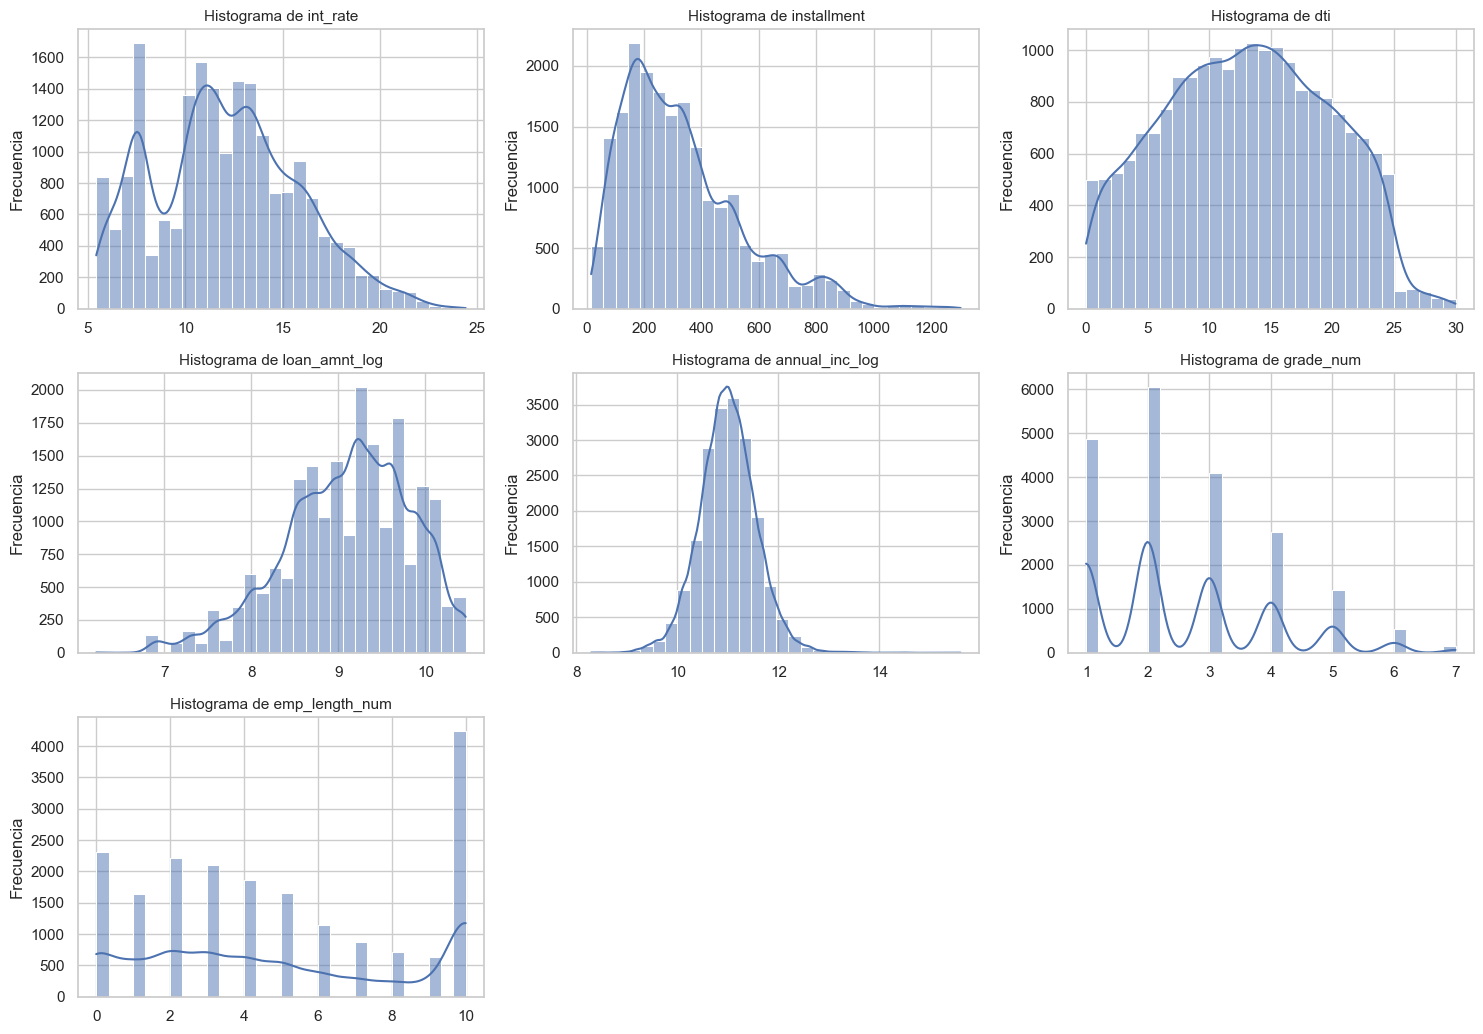


--- Comparación log antes vs después ---


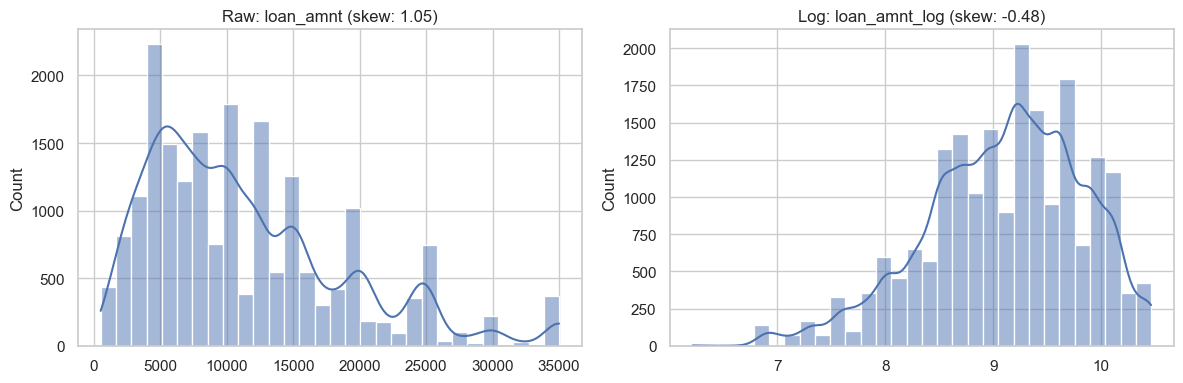

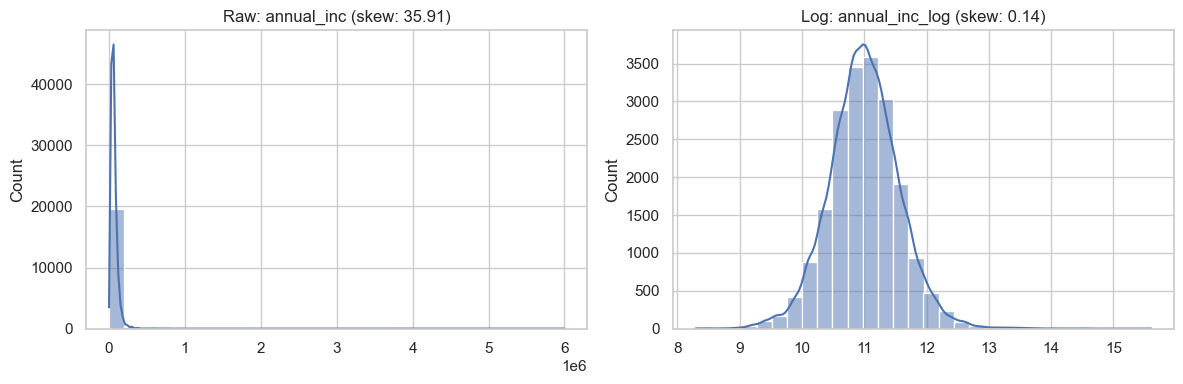


--- Boxplots ---


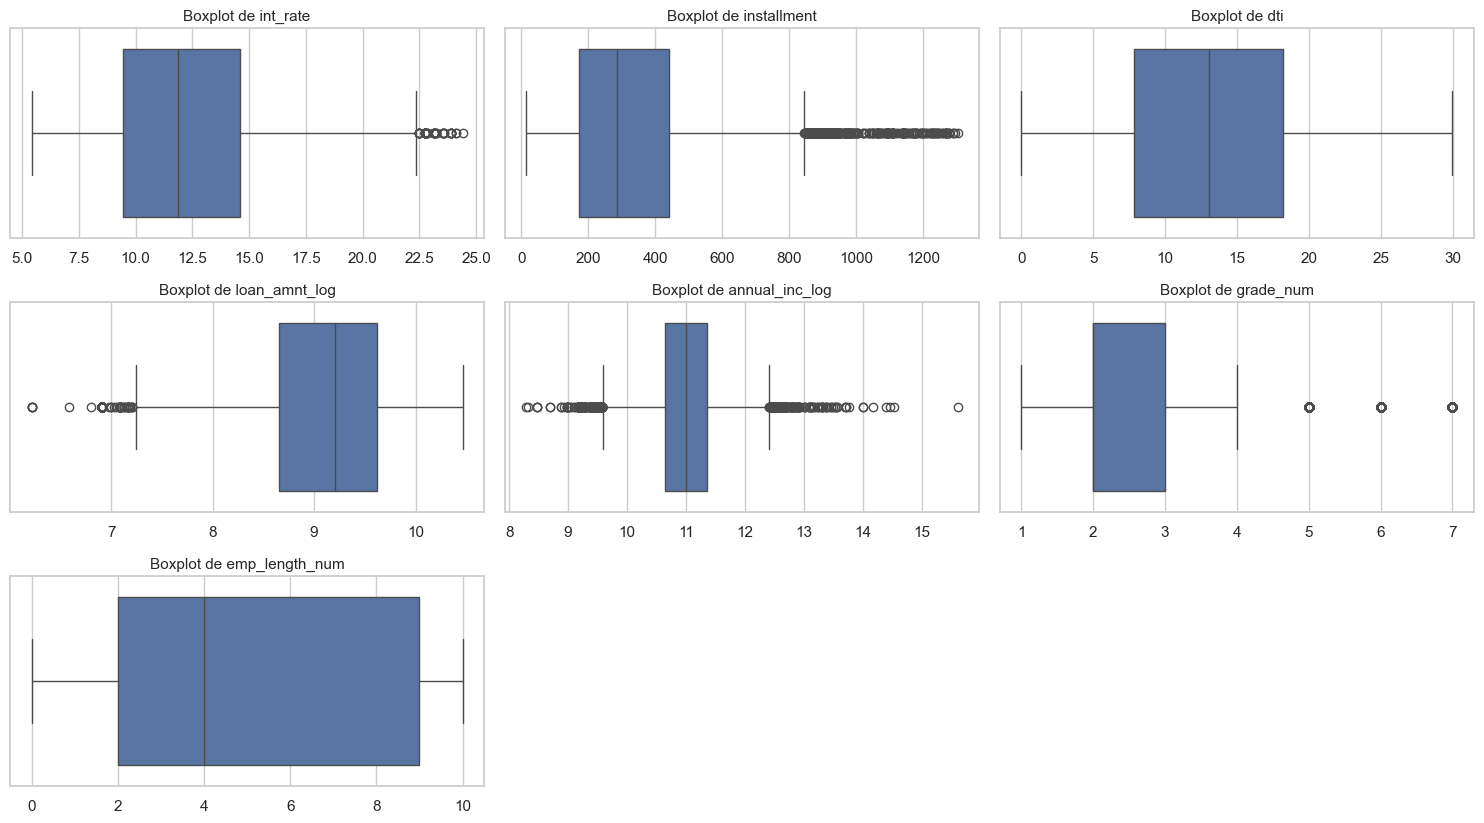


--- Barplots (variables discretas) ---


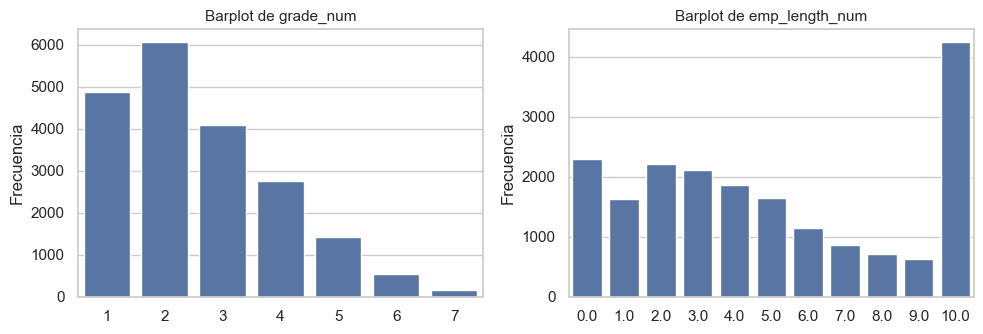

In [214]:
eda_univariado_numericas(df_raw, df_inter_cols, num_raw, num_inter)


Variables categóricas analizadas:
['term', 'emp_title', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

--- Countplots (Top 10 categorías) ---


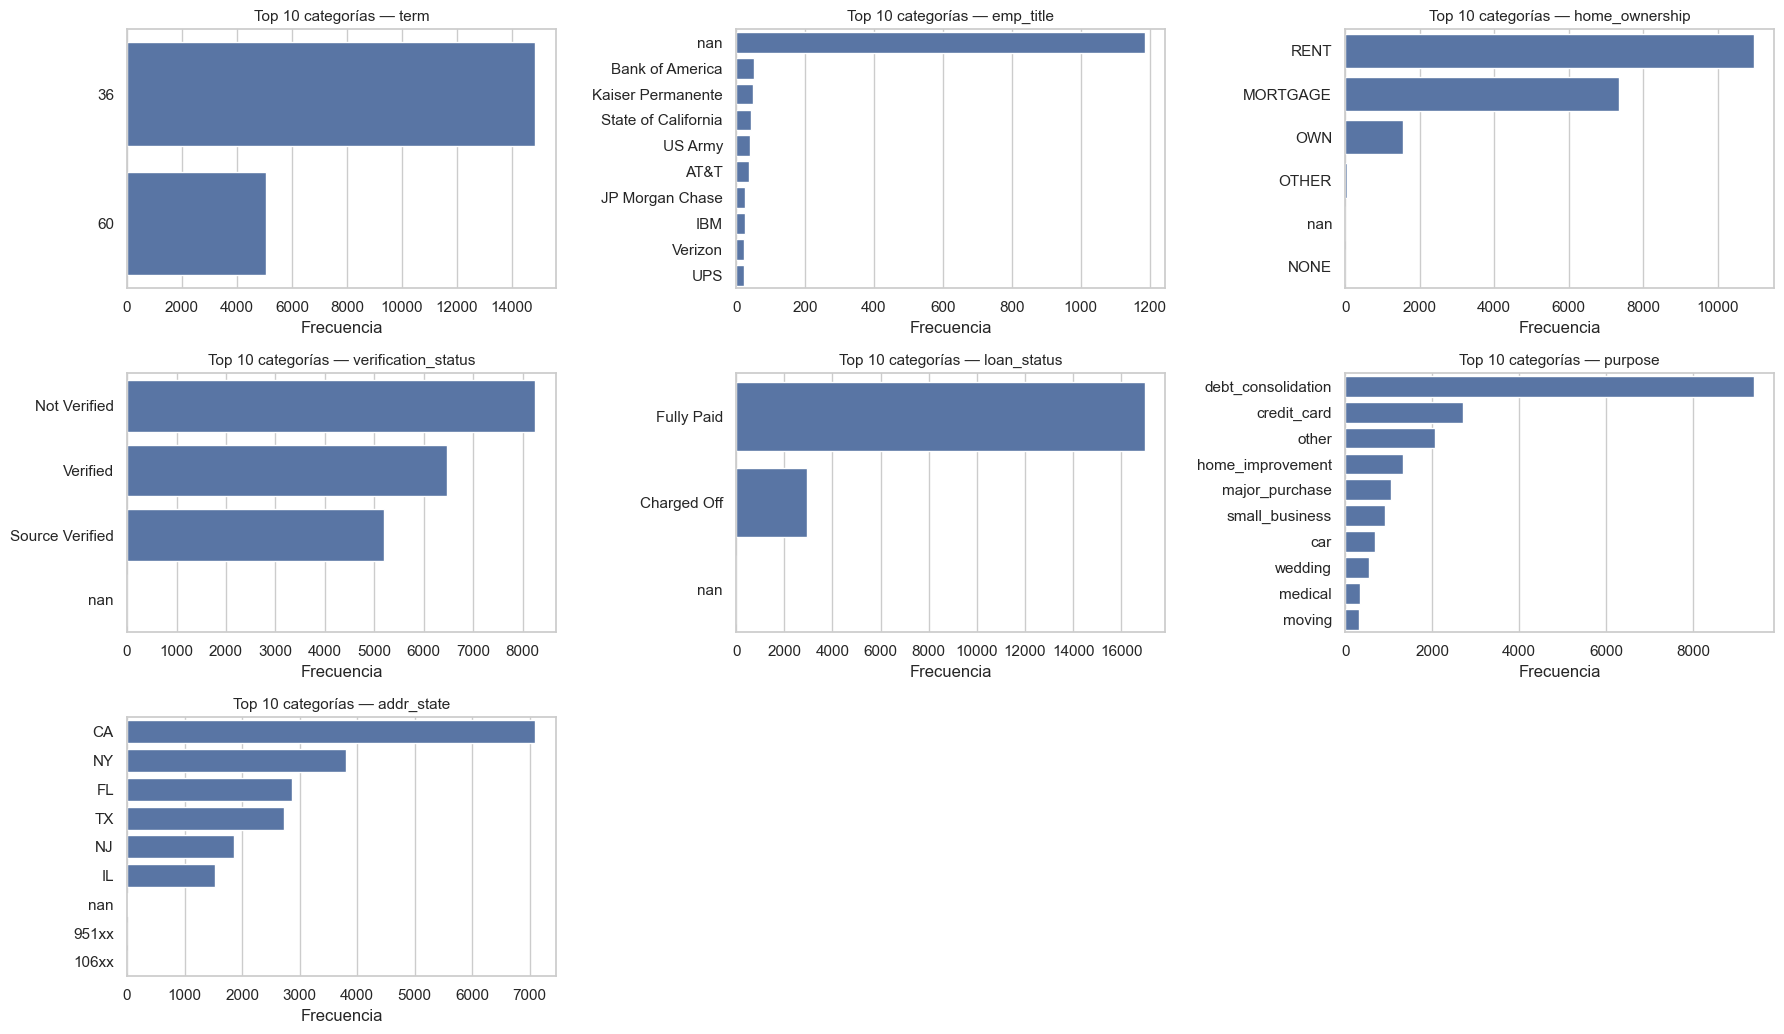


--- Tablas de frecuencia (Top 10) ---

Variable categórica: term


,frecuencia,frecuencia_relativa
term,,
36,14852,0.746
60,5056,0.254



Variable categórica: emp_title


,frecuencia,frecuencia_relativa
emp_title,,
nan,1185,0.060
Bank of America,53,0.003
Kaiser Permanente,50,0.003
State of California,43,0.002
US Army,41,0.002
AT&T,36,0.002
JP Morgan Chase,27,0.001
IBM,26,0.001
Verizon,24,0.001



Variable categórica: home_ownership


,frecuencia,frecuencia_relativa
home_ownership,,
RENT,10965,0.551
MORTGAGE,7349,0.369
OWN,1546,0.078
OTHER,44,0.002
nan,3,0.000
NONE,1,0.000



Variable categórica: verification_status


,frecuencia,frecuencia_relativa
verification_status,,
Not Verified,8256,0.415
Verified,6464,0.325
Source Verified,5185,0.260
nan,3,0.000



Variable categórica: loan_status


,frecuencia,frecuencia_relativa
loan_status,,
Fully Paid,16962,0.852
Charged Off,2943,0.148
nan,3,0.000



Variable categórica: purpose


,frecuencia,frecuencia_relativa
purpose,,
debt_consolidation,9387,0.472
credit_card,2696,0.135
other,2059,0.103
home_improvement,1330,0.067
major_purchase,1048,0.053
small_business,905,0.045
car,687,0.035
wedding,539,0.027
medical,350,0.018



Variable categórica: addr_state


,frecuencia,frecuencia_relativa
addr_state,,
CA,7101,0.357
NY,3813,0.192
FL,2870,0.144
TX,2733,0.137
NJ,1855,0.093
IL,1525,0.077
nan,9,0.000
951xx,1,0.000
106xx,1,0.000


In [212]:
eda_univariado_categoricas(df_inter, cat_inter)

## 5) EDA bivariado: variables explicativas vs target

In [217]:
TARGET_CLAS = "loan_status"
cat_inter.remove(TARGET_CLAS)

### 5.2 Para Clasificación

#### 5.2.1) Numéricas vs Target

In [218]:
def eda_bivariado_numericas_vs_target_clas(df, num_cols, target, q=5):
    """
    Análisis bivariado completo de variables numéricas vs target para clasificación.   
    Args:
        df: DataFrame a analizar
        num_cols: Lista de columnas numéricas
        target: Variable objetivo (categórica binaria)
        q: Número de buckets/quintiles
    """
    # Configuración inicial
    target_classes = df[target].unique()
    print(f"\n{'='*60}")
    print(f"EDA BIVARIADO: NUMÉRICAS vs TARGET ({target})")
    print(f"{'='*60}")
    print(f"Clases del target: {target_classes}")
    print(f"Variables numéricas: {num_cols}")
    
    # Crear variable binaria para cálculos
    df_temp = df.copy()
    df_temp['target_bin'] = (df_temp[target] == target_classes[0]).astype(int)
    
    # Parámetros visuales
    n_vars = len(num_cols)
    n_cols_plot = min(3, n_vars) if n_vars > 1 else 1
    n_rows_plot = math.ceil(n_vars / n_cols_plot)
    
    # =========================================
    # 1. BOXPLOTS POR CLASE (grid)
    # =========================================
    print("\n--- 1. Boxplots por clase ---")
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    
    # Convertir axes a array 1D siempre
    if n_vars == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()
    
    for i, col in enumerate(num_cols):
        sns.boxplot(data=df_temp, x=target, y=col, ax=axes[i])
        axes[i].set_title(f'{col} por {target}', fontsize=11)
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(col)
    
    # Ocultar ejes vacíos
    for j in range(len(num_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_boxplots_por_clase.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # =========================================
    # 2. TASAS POR BUCKETS (grid)
    # =========================================
    print("\n--- 2. Tasa del target por buckets ---")
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    
    # Convertir axes a array 1D siempre
    if n_vars == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()
    
    tasa_global = df_temp['target_bin'].mean()
    
    tablas_resumen = []
    
    for i, col in enumerate(num_cols):
        df_col = df_temp[[col, 'target_bin']].dropna()
        
        if df_col.empty:
            axes[i].set_visible(False)
            continue
        
        # Intentar crear buckets, si falla usar menos buckets o saltear
        try:
            df_col['bucket'] = pd.qcut(df_col[col], q=q, duplicates='drop')
            n_buckets = df_col['bucket'].nunique()
            
            if n_buckets < 2:
                print(f"  ⚠️ {col}: Solo {n_buckets} bucket(s), saltando...")
                axes[i].set_visible(False)
                continue
                
        except ValueError as e:
            print(f"  ⚠️ {col}: No se pudo crear buckets - {e}")
            axes[i].set_visible(False)
            continue
        
        stats = df_col.groupby('bucket').agg(
            n=('target_bin', 'count'),
            tasa_target=('target_bin', 'mean')
        ).round(4).reset_index()
        
        stats['variable'] = col
        tablas_resumen.append(stats)
        
        # Gráfico
        axes[i].bar(range(len(stats)), stats['tasa_target'], color='steelblue', edgecolor='black')
        axes[i].axhline(y=tasa_global, color='red', linestyle='--', label='Tasa global')
        axes[i].set_title(f'Tasa de {target_classes[0]} por quintiles de {col}', fontsize=10)
        axes[i].set_xlabel(f'Quintiles de {col}')
        axes[i].set_ylabel(f'Tasa')
        axes[i].set_xticks(range(len(stats)))
        axes[i].set_xticklabels([str(b)[:15] for b in stats['bucket']], rotation=45, ha='right', fontsize=8)
        axes[i].legend(fontsize=8)
    
    # Ocultar ejes vacíos
    for j in range(len(num_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_tasas_por_buckets.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar tablas de resumen
    print("\n--- Tablas de tasas por buckets ---")
    if not tablas_resumen:
        print("No se generaron tablas de resumen.")
    else:
        for tabla in tablas_resumen:
            if len(tabla) > 0:
                var = tabla['variable'].iloc[0]
                print(f"\n{var}:")
                display(tabla[['bucket', 'n', 'tasa_target']])
    
    # =========================================
    # 3. ANÁLISIS DE TENDENCIA
    # =========================================
    print("\n--- 3. Análisis de tendencia (monotonía) ---")
    
    tendencias = []
    for col in num_cols:
        df_col = df_temp[[col, 'target_bin']].dropna()
        
        if df_col.empty:
            continue
        
        try:
            df_col['bucket'] = pd.qcut(df_col[col], q=q, duplicates='drop')
            
            if df_col['bucket'].nunique() < 2:
                continue
                
            tasas = df_col.groupby('bucket')['target_bin'].mean().values
            
            if len(tasas) < 2:
                continue
                
            diffs = np.diff(tasas)
            
            if np.all(diffs >= 0):
                tendencia = 'Creciente ↑'
            elif np.all(diffs <= 0):
                tendencia = 'Decreciente ↓'
            else:
                tendencia = 'No monótona ↕'
            
            tendencias.append({
                'variable': col,
                'tendencia': tendencia,
                'tasas_por_bucket': np.round(tasas, 4).tolist()
            })
        except ValueError:
            continue
    
    if tendencias:
        tendencias_df = pd.DataFrame(tendencias)
        display(tendencias_df)
    else:
        print("No se pudo calcular tendencias para ninguna variable.")


EDA BIVARIADO: NUMÉRICAS vs TARGET (loan_status)
Clases del target: ['Fully Paid' 'Charged Off']
Variables numéricas: ['int_rate', 'installment', 'dti', 'loan_amnt_log', 'annual_inc_log', 'grade_num', 'emp_length_num']

--- 1. Boxplots por clase ---


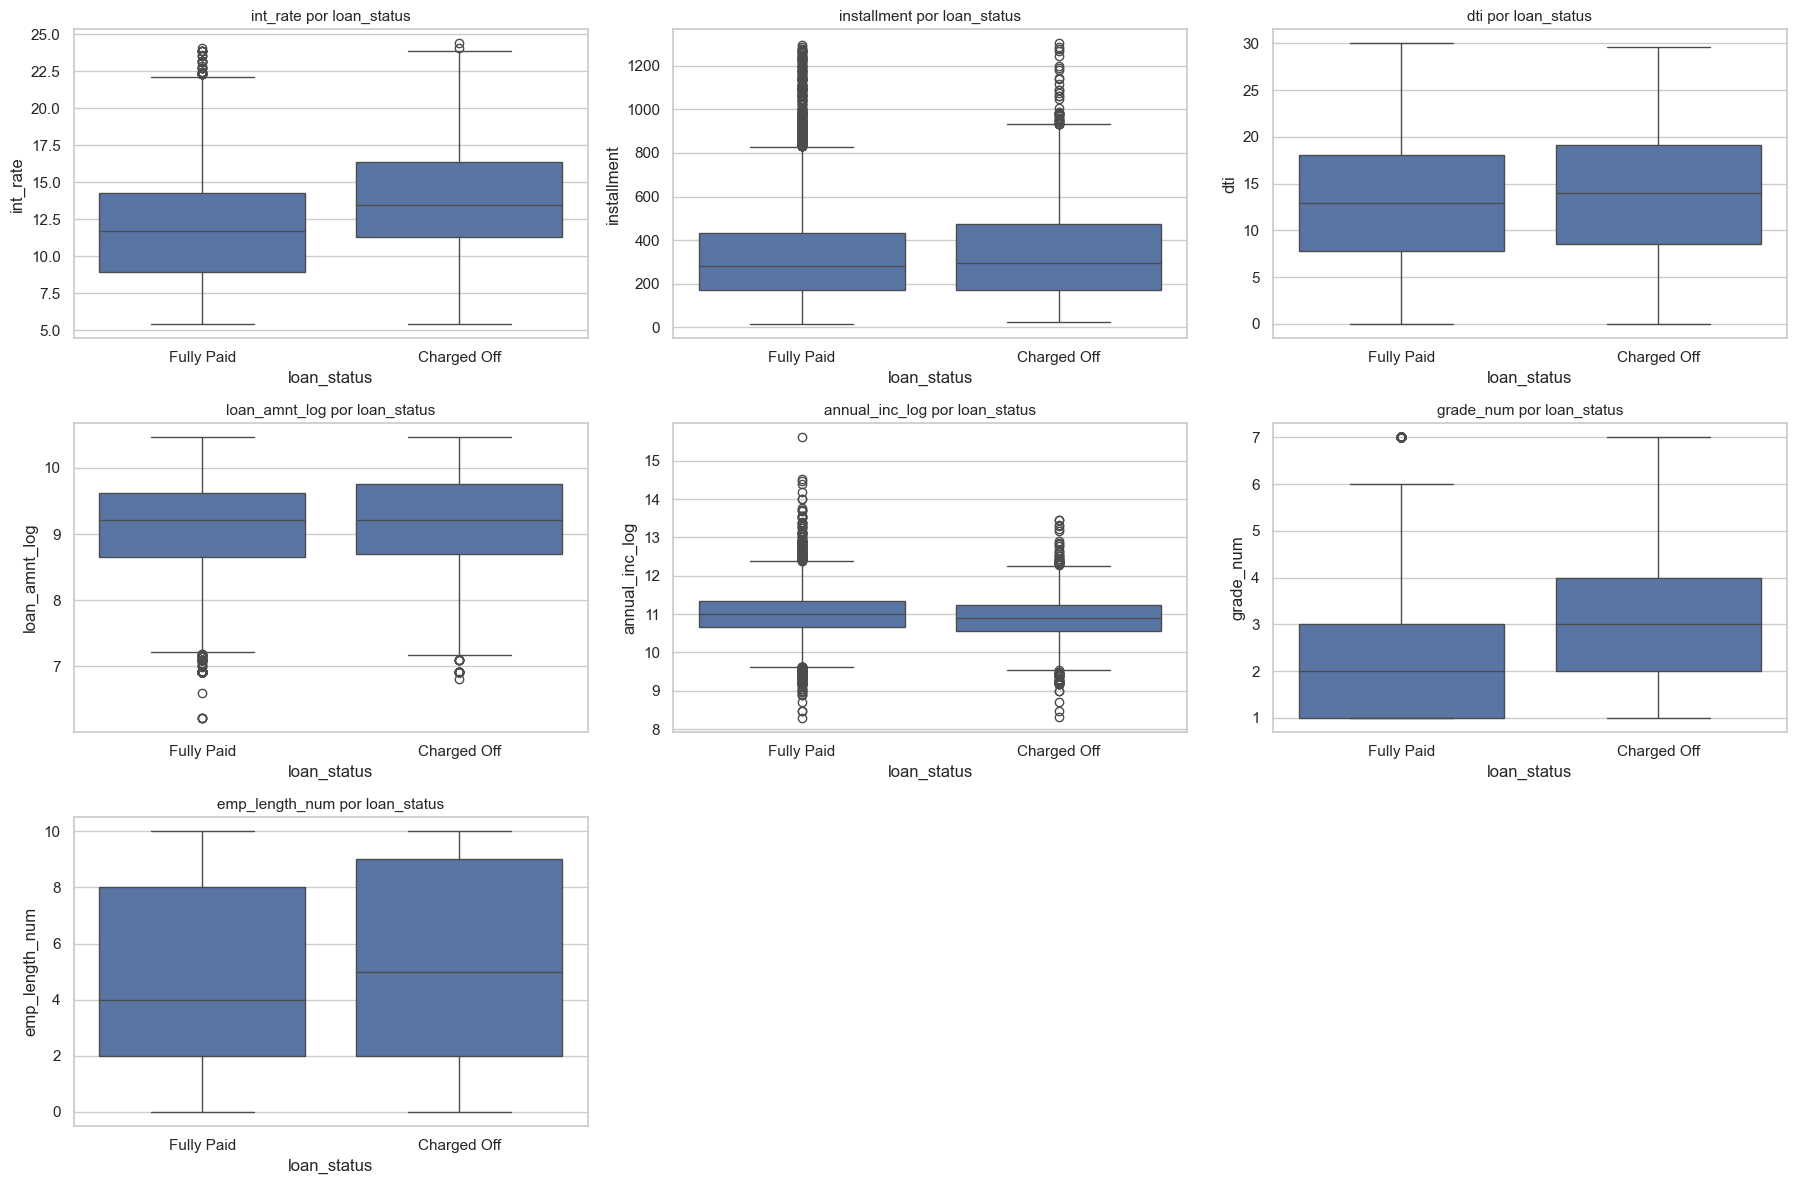


--- 2. Tasa del target por buckets ---


C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_col.groupby('bucket').agg(
C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_col.groupby('bucket').agg(
C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats 

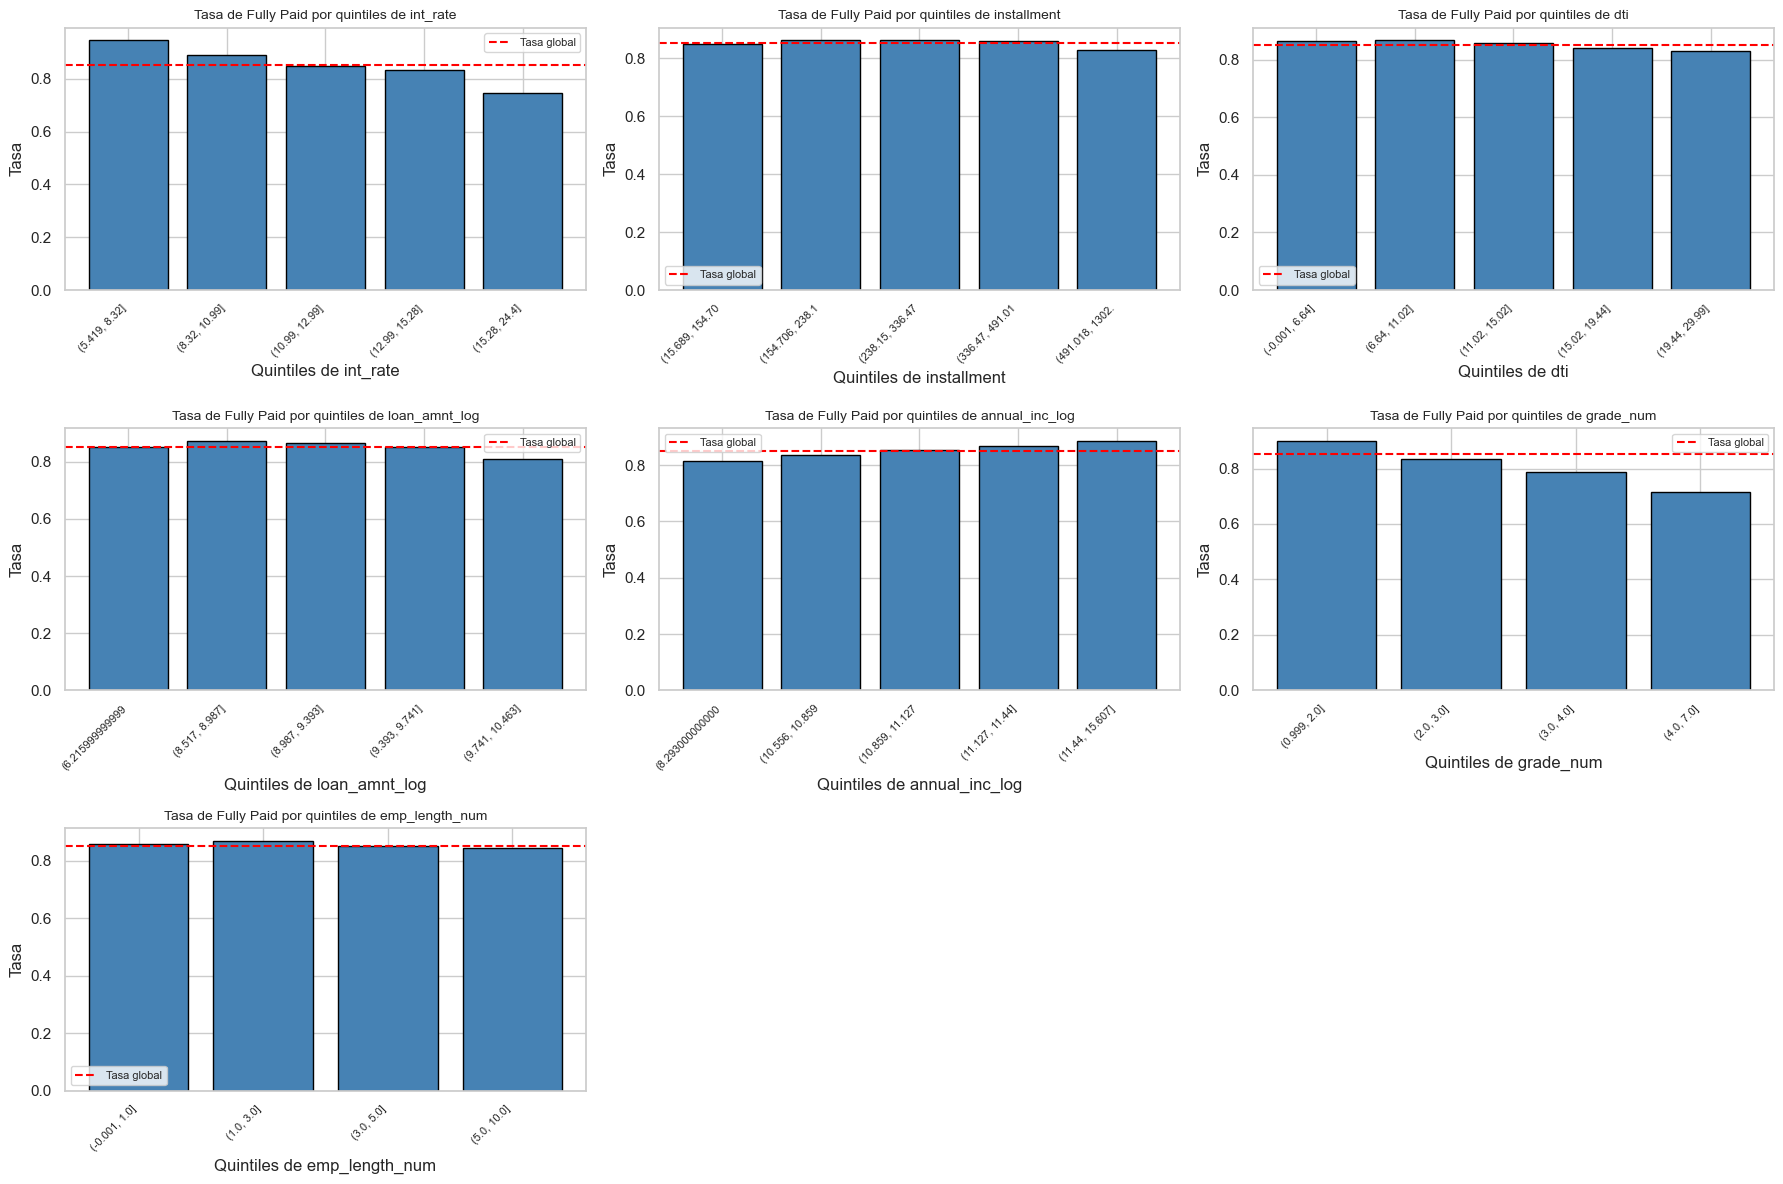


--- Tablas de tasas por buckets ---

int_rate:


,bucket,n,tasa_target
0,"(5.419, 8.32]",3992,0.9454
1,"(8.32, 10.99]",4056,0.8878
2,"(10.99, 12.99]",4039,0.8482
3,"(12.99, 15.28]",3896,0.8314
4,"(15.28, 24.4]",3916,0.7446



installment:


,bucket,n,tasa_target
0,"(15.689, 154.706]",3980,0.8487
1,"(154.706, 238.15]",3986,0.8628
2,"(238.15, 336.47]",3973,0.8623
3,"(336.47, 491.018]",3980,0.8585
4,"(491.018, 1302.69]",3980,0.8281



dti:


,bucket,n,tasa_target
0,"(-0.001, 6.64]",3981,0.8659
1,"(6.64, 11.02]",3984,0.8675
2,"(11.02, 15.02]",3981,0.8563
3,"(15.02, 19.44]",3978,0.8421
4,"(19.44, 29.99]",3973,0.8286



loan_amnt_log:


,bucket,n,tasa_target
0,"(6.215999999999999, 8.517]",4575,0.8520
1,"(8.517, 8.987]",4000,0.8748
2,"(8.987, 9.393]",4434,0.8676
3,"(9.393, 9.741]",2985,0.8519
4,"(9.741, 10.463]",3905,0.8115



annual_inc_log:


,bucket,n,tasa_target
0,"(8.293000000000001, 10.556]",3982,0.8154
1,"(10.556, 10.859]",4084,0.8350
2,"(10.859, 11.127]",3913,0.8543
3,"(11.127, 11.44]",3944,0.8689
4,"(11.44, 15.607]",3976,0.8876



grade_num:


,bucket,n,tasa_target
0,"(0.999, 2.0]",10935,0.9010
1,"(2.0, 3.0]",4085,0.8355
2,"(3.0, 4.0]",2747,0.7892
3,"(4.0, 7.0]",2132,0.7144



emp_length_num:


,bucket,n,tasa_target
0,"(-0.001, 1.0]",3940,0.8584
1,"(1.0, 3.0]",4324,0.8693
2,"(3.0, 5.0]",3519,0.8511
3,"(5.0, 10.0]",7617,0.8435



--- 3. Análisis de tendencia (monotonía) ---


C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasas = df_col.groupby('bucket')['target_bin'].mean().values
C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasas = df_col.groupby('bucket')['target_bin'].mean().values
C:\Users\leydi\AppData\Local\Temp\ipykernel_19000\1637109879.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

,variable,tendencia,tasas_por_bucket
0,int_rate,Decreciente ↓,"[0.9454, 0.8878, 0.8482, 0.8314, 0.7446]"
1,installment,No monótona ↕,"[0.8487, 0.8628, 0.8623, 0.8585, 0.8281]"
2,dti,No monótona ↕,"[0.8659, 0.8675, 0.8563, 0.8421, 0.8286]"
3,loan_amnt_log,No monótona ↕,"[0.852, 0.8748, 0.8676, 0.8519, 0.8115]"
4,annual_inc_log,Creciente ↑,"[0.8154, 0.835, 0.8543, 0.8689, 0.8876]"
5,grade_num,Decreciente ↓,"[0.901, 0.8355, 0.7892, 0.7144]"
6,emp_length_num,No monótona ↕,"[0.8584, 0.8693, 0.8511, 0.8435]"


In [219]:
# Aplicar análisis de numéricas vs target para clasificación

eda_bivariado_numericas_vs_target_clas(df_inter_cols, num_inter, TARGET_CLAS)

#### 5.1.2) Categóricas vs Target

In [220]:
def analisis_categorias_vs_target(df, cat_cols, target, top_k=15):
    """
    Qué hacer: medir la señal del target (tasa) y la cobertura (n) por categoría.
    Por qué: priorizar grupos con poder predictivo y descartar los de baja evidencia.
    Orden/función:
        1. Preparar tasa global del target y contenedores de resultados.
        2. Para cada columna categórica, calcular tasas y frecuencias (groupby).
        3. Graficar todo en dos lienzos agrupados (tasa vs. registros).
        4. Dejar evidencia tabular y alertas de categorías raras.
    Evidencia a dejar: figuras guardadas en graphs, tablas mostradas en notebook y advertencias impresas.
    """
    target_classes = df[target].dropna().unique()
    if target_classes.size == 0:
        print("Target sin clases válidas.")
        return
    foco = target_classes[0]
    global_rate = (df[target] == foco).mean()

    tasa_por_col = {}
    registros_por_col = {}
    columnas_validas = []

    for col in cat_cols:
        df_temp = df[[col, target]].dropna()
        if df_temp.empty:
            print(f"Sin datos para {col}")
            continue
        df_temp['target_bin'] = (df_temp[target] == foco).astype(int)

        tasas = (
            df_temp.groupby(col)['target_bin']
            .agg(['mean', 'count'])
            .rename(columns={'mean': 'tasa_target', 'count': 'n'})
            .sort_values('tasa_target', ascending=False)
            .reset_index()
        )
        tasa_por_col[col] = tasas

        conteos = (
            df_temp.groupby(col)['target_bin']
            .size()
            .reset_index(name='n')
            .sort_values('n', ascending=False)
            .reset_index(drop=True)
        )
        conteos['pct_total'] = (conteos['n'] / conteos['n'].sum() * 100).round(2)
        registros_por_col[col] = conteos
        columnas_validas.append(col)

    if not columnas_validas:
        print("No se generó evidencia para las columnas solicitadas.")
        return

    n_plots = len(columnas_validas)
    n_cols_plot = 2 if n_plots <= 4 else 3
    n_rows_plot = math.ceil(n_plots / n_cols_plot)

    # Figura 1: tasas por categoría
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    axes = np.array(axes).flatten() if n_plots > 1 else [axes]
    for idx, col in enumerate(columnas_validas):
        top_stats = tasa_por_col[col].head(top_k)
        axes[idx].bar(range(len(top_stats)), top_stats['tasa_target'], color='steelblue', edgecolor='black')
        axes[idx].axhline(global_rate, color='red', linestyle='--', label=f"Tasa global: {global_rate:.3f}")
        axes[idx].set_title(f"Tasa {foco} — {col}", fontsize=10)
        axes[idx].set_ylabel('Tasa')
        axes[idx].set_xticks(range(len(top_stats)))
        axes[idx].set_xticklabels(top_stats[col].astype(str), rotation=45, ha='right')
        axes[idx].legend(fontsize=8)
    for j in range(len(columnas_validas), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_tasa_por_categoria.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Figura 2: registros por categoría
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    axes = np.array(axes).flatten() if n_plots > 1 else [axes]
    for idx, col in enumerate(columnas_validas):
        top_counts = registros_por_col[col].head(top_k)
        axes[idx].bar(range(len(top_counts)), top_counts['n'], color='mediumpurple', edgecolor='black')
        axes[idx].set_title(f"Registros — {col}", fontsize=10)
        axes[idx].set_ylabel('n')
        axes[idx].set_xticks(range(len(top_counts)))
        axes[idx].set_xticklabels(top_counts[col].astype(str), rotation=45, ha='right')
    for j in range(len(columnas_validas), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_registros_por_categoria.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Evidencia tabular
    for col in columnas_validas:
        print(f"\n{'='*50}")
        print(f"Tasa de '{foco}' por categoría: {col}")
        print(f"{'='*50}")
        display(tasa_por_col[col])

        print(f"\n{'-'*50}")
        print(f"Registros por categoría: {col}")
        print(f"{'-'*50}")
        conteos = registros_por_col[col]
        display(conteos)
        raras = conteos[conteos['pct_total'] < 1]
        if not raras.empty:
            print(f"⚠️ Categorías raras (<1%): {len(raras)} de {len(conteos)}")
            display(raras)

    print(f"\n✅ Gráficos guardados en: {GRAPHS_PATH_LENDING}")

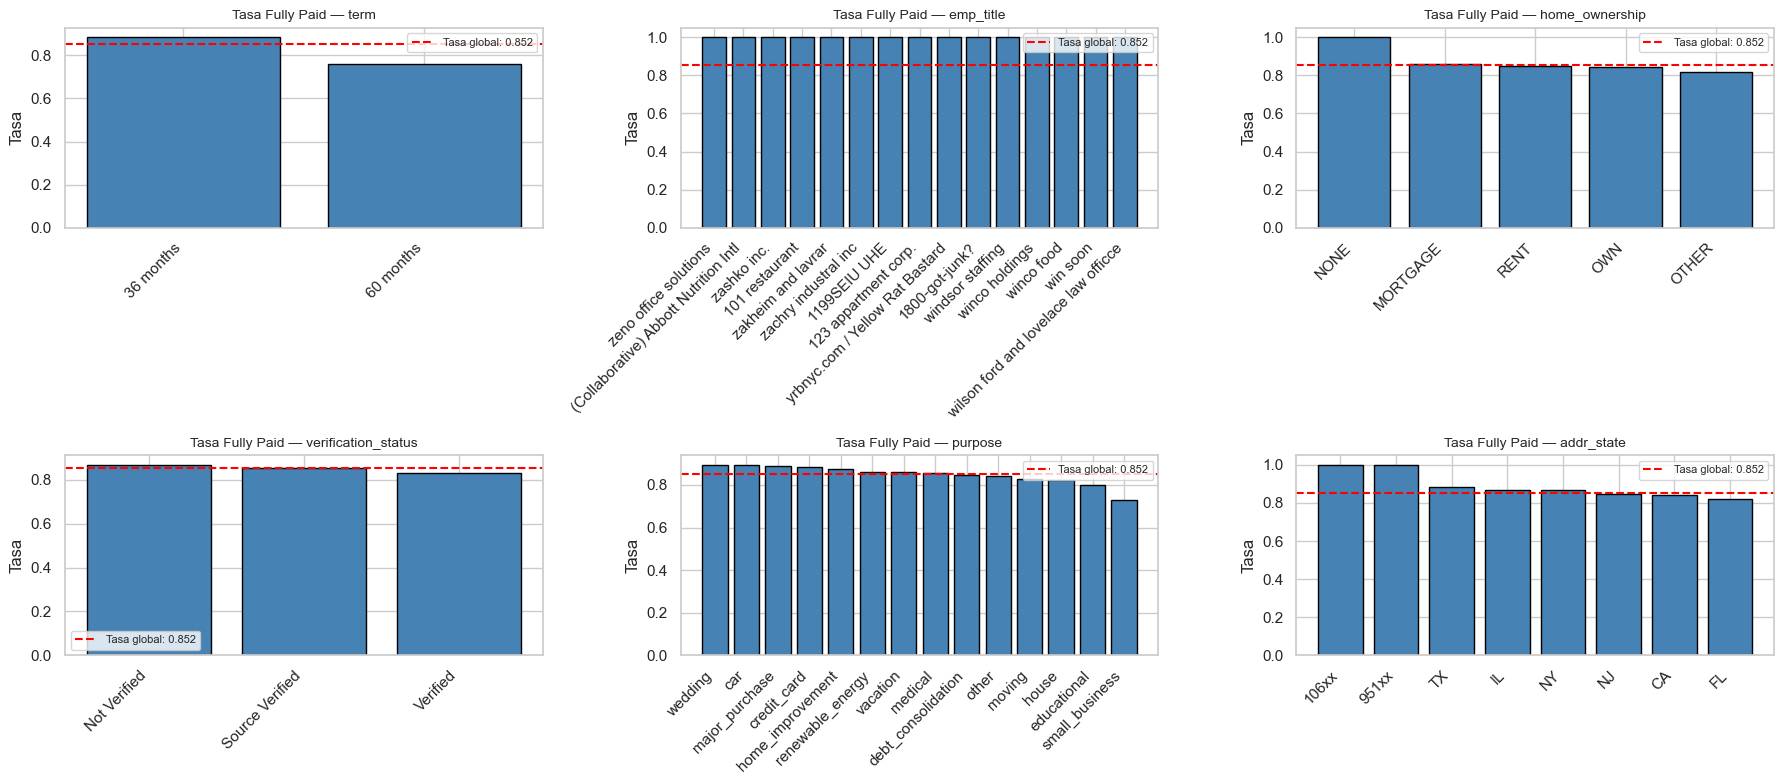

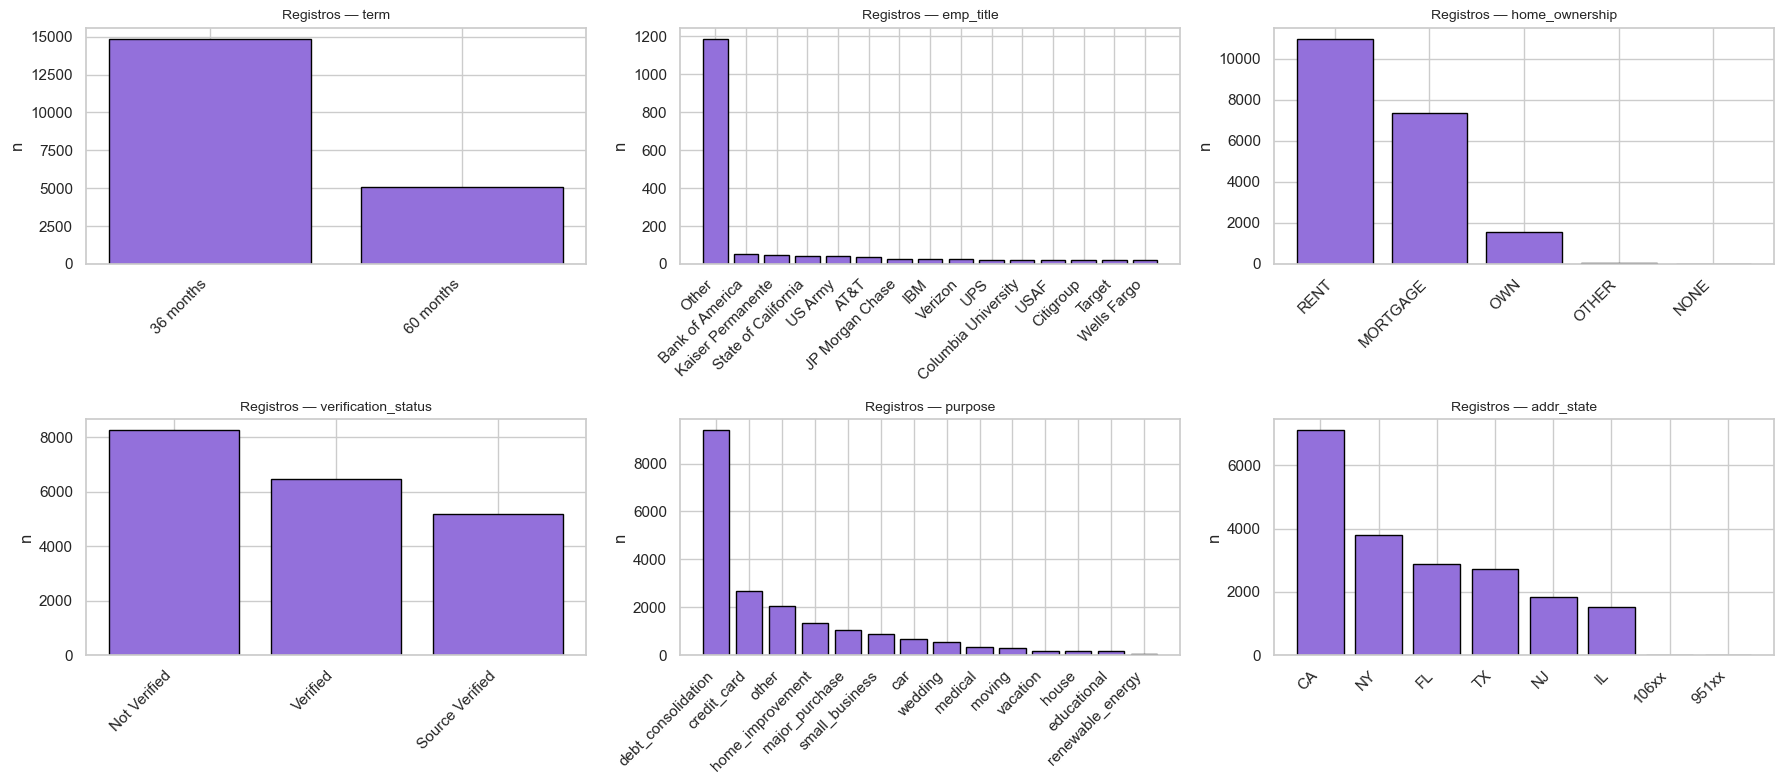


Tasa de 'Fully Paid' por categoría: term


,term,tasa_target,n
0,36 months,0.883597,14845
1,60 months,0.759596,5054



--------------------------------------------------
Registros por categoría: term
--------------------------------------------------


,term,n,pct_total
0,36 months,14845,74.6
1,60 months,5054,25.4



Tasa de 'Fully Paid' por categoría: emp_title


,emp_title,tasa_target,n
0,zeno office solutions,1.0,1
1,(Collaborative) Abbott Nutrition Intl,1.0,1
2,zashko inc.,1.0,1
3,101 restaurant,1.0,1
4,zakheim and lavrar,1.0,1
...,...,...,...
14922,University of Utah,0.0,1
14923,Superior Manufactured Homes,0.0,1
14924,State if Calif,0.0,1
14925,Stenocall,0.0,1



--------------------------------------------------
Registros por categoría: emp_title
--------------------------------------------------


,emp_title,n,pct_total
0,Other,1185,5.96
1,Bank of America,53,0.27
2,Kaiser Permanente,50,0.25
3,State of California,43,0.22
4,US Army,41,0.21
...,...,...,...
14922,wny urology associates,1,0.01
14923,wood you furniture,1,0.01
14924,world confections inc,1,0.01
14925,wrisco,1,0.01


⚠️ Categorías raras (<1%): 14926 de 14927


,emp_title,n,pct_total
1,Bank of America,53,0.27
2,Kaiser Permanente,50,0.25
3,State of California,43,0.22
4,US Army,41,0.21
5,AT&T,36,0.18
...,...,...,...
14922,wny urology associates,1,0.01
14923,wood you furniture,1,0.01
14924,world confections inc,1,0.01
14925,wrisco,1,0.01



Tasa de 'Fully Paid' por categoría: home_ownership


,home_ownership,tasa_target,n
0,NONE,1.000000,1
1,MORTGAGE,0.861304,7347
2,RENT,0.847550,10961
3,OWN,0.841527,1546
4,OTHER,0.818182,44



--------------------------------------------------
Registros por categoría: home_ownership
--------------------------------------------------


,home_ownership,n,pct_total
0,RENT,10961,55.08
1,MORTGAGE,7347,36.92
2,OWN,1546,7.77
3,OTHER,44,0.22
4,NONE,1,0.01


⚠️ Categorías raras (<1%): 2 de 5


,home_ownership,n,pct_total
3,OTHER,44,0.22
4,NONE,1,0.01



Tasa de 'Fully Paid' por categoría: verification_status


,verification_status,tasa_target,n
0,Not Verified,0.867943,8254
1,Source Verified,0.851959,5181
2,Verified,0.831993,6464



--------------------------------------------------
Registros por categoría: verification_status
--------------------------------------------------


,verification_status,n,pct_total
0,Not Verified,8254,41.48
1,Verified,6464,32.48
2,Source Verified,5181,26.04



Tasa de 'Fully Paid' por categoría: purpose


,purpose,tasa_target,n
0,wedding,0.894052,538
1,car,0.892285,687
2,major_purchase,0.887405,1048
3,credit_card,0.885714,2695
4,home_improvement,0.875094,1329
5,renewable_energy,0.862745,51
6,vacation,0.859296,199
7,medical,0.854286,350
8,debt_consolidation,0.845605,9385
9,other,0.843613,2059



--------------------------------------------------
Registros por categoría: purpose
--------------------------------------------------


,purpose,n,pct_total
0,debt_consolidation,9385,47.16
1,credit_card,2695,13.54
2,other,2059,10.35
3,home_improvement,1329,6.68
4,major_purchase,1048,5.27
5,small_business,905,4.55
6,car,687,3.45
7,wedding,538,2.70
8,medical,350,1.76
9,moving,316,1.59


⚠️ Categorías raras (<1%): 3 de 14


,purpose,n,pct_total
11,house,176,0.88
12,educational,161,0.81
13,renewable_energy,51,0.26



Tasa de 'Fully Paid' por categoría: addr_state


,addr_state,tasa_target,n
0,106xx,1.000000,1
1,951xx,1.000000,1
2,TX,0.882181,2733
3,IL,0.870164,1525
4,NY,0.868607,3813
5,NJ,0.847978,1855
6,CA,0.840727,7101
7,FL,0.822648,2870



--------------------------------------------------
Registros por categoría: addr_state
--------------------------------------------------


,addr_state,n,pct_total
0,CA,7101,35.69
1,NY,3813,19.16
2,FL,2870,14.42
3,TX,2733,13.73
4,NJ,1855,9.32
5,IL,1525,7.66
6,106xx,1,0.01
7,951xx,1,0.01


⚠️ Categorías raras (<1%): 2 de 8


,addr_state,n,pct_total
6,106xx,1,0.01
7,951xx,1,0.01



✅ Gráficos guardados en: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07\graphs\data_lending


In [221]:
# Aplicar análisis de categóricas vs target para clasificación
analisis_categorias_vs_target(df_inter_cols, cat_inter, TARGET_CLAS)